## Code used for cleaning up and organizing the log results from MOA

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from IPython.display import display
from collections import Counter
import glob
pd.set_option('display.max_rows', 300)

In [5]:
drift_detectors_params = [
                            {"id": "DDM", "drift_name": "DDM", "params": ""},    \
                            {"id": "EDDM", "drift_name": "EDDM", "params": ""},   \
                            {"id": "ADWIN", "drift_name": "ADWINChangeDetector", "params": ""},  \
                            {"id": "ECDD", "drift_name": "EWMAChartDM", "params": ""},   \
                            {"id": "STEPD", "drift_name": "STEPD", "params": ""},  \
                            {"id": "SeqDrift2", "drift_name": "SeqDrift2ChangeDetector", "params": ""},  \
                            {"id": "SEED", "drift_name": "SEEDChangeDetector", "params": ""},   \
                            {"id": "HDDM_A_Test", "drift_name": "HDDM_A_Test", "params": ""},  \
                            {"id": "HDDM_W_Test", "drift_name": "HDDM_W_Test", "params": ""},  \
                            #{"id": "FHDDM", "drift_name": "FHDDM", "params": ""},  \
                            #{"id": "FTDD", "drift_name": "FTDD", "params": ""},   \
                            {"id": "RDDM_30", "drift_name": "RDDM", "params": "-n 30 -w 2 -o 3"}, \
                            {"id": "RDDM","drift_name": "RDDM", "params": ""},   \
                            #{"id": "WSTD","drift_name": "WSTD", "params": ""},    \
                            {"id": "HypothesisTestDetectorKs","drift_name": "HypothesisTestDetector", "params": "-h ks"},    \
                            {"id": "HypothesisTestDetectorWrs","drift_name": "HypothesisTestDetector", "params": "-h wrs"},    \
                            {"id": "HypothesisTestDetectorTt","drift_name": "HypothesisTestDetector", "params": "-h tt"},    \
                            {"id": "MultivariateDetector","drift_name": "moa.learners.ChangeDetectorEnsembleMultivariateLearner", "params": "-d (PageHinkleyDM -d 0.002) -p 20"},    \
                            {"id": "Studd","drift_name": "moa.learners.StuddLearner", "params": "-b (meta.AdaptiveRandomForest -u  -q -w) -s (meta.AdaptiveRandomForest -u  -q -w) -d (PageHinkleyDM -d 0.002) -w 500"},    \
                            #{"id": "NoChangeDetector","drift_name": "NoChangeDetectorNaive", "params": "-n 1000"}                        
                        ]

In [68]:
def avg_last_execution(files_path, drift_detector, generator, metric, delay):
    
    results = []
    for file in files_path:
        #print(file)
        df = pd.read_csv(file)
        #print(df.iloc[-1][metric])
        value = df.iloc[-1][metric]
        
        if value == "?":
            value = 0
        
        results.append(round(float(value), 2))
        #print(f'Value: {value}')
    
    tuple_results = tuple([np.mean(results), np.std(results), drift_detector, generator, delay])
   
    # print(f'avg of all last execution: {np.mean(results)}')
    return tuple_results 

In [64]:

def aggregate_iteration_csv(classifier, drift_size, delay_labeled, type_drift, metric_name, dict_drift_type, drift_detectors_params):

    df_final_result = pd.DataFrame()
    for drift_key, drift_value in dict_drift_type.items():    

        tuple_list_result = list()
        for drift in drift_detectors_params:
            for delay in delay_labeled:
                files_path = glob.glob(f'../results/delay/{drift_key}/{classifier}_{drift["id"]}_{drift_size}_{delay}_*_{drift_value}_{type_drift}.csv')
                tuple_result = avg_last_execution(files_path, drift["id"], drift_value, metric_name, delay)
                tuple_list_result.append(tuple_result)
                            
        df_result = pd.DataFrame(tuple_list_result, columns=['avg', 'std', 'drift_detector', 'generator', 'delay'])
        df_final_result = pd.concat([df_final_result, df_result])

    df_final_result
    df_final_result.to_csv(f'../results/delay/csv_aggregation/{type_drift}_{metric_name}_{drift_size}.csv', index=False)

#df_result_pivot = df_final_result.reset_index().pivot(index="generator", columns="drift_detector", values="avg")
#df_result_pivot

In [1]:
def avg_percentil_last_execution(files_path, drift_detector, generator, metric, delay):
    
    results = []
    for file in files_path:
        #print(file)
        df = pd.read_csv(file)
        #print(df.iloc[-1][metric])
        value = df.iloc[-1][metric]
        
        if value == "?":
            value = 0
        
        results.append(round(float(value), 2))
        #print(f'Value: {value}')
    
    tuple_results = tuple([np.median(results), np.percentile(results, 75) - np.percentile(results, 25), drift_detector, generator, delay])
   
    # print(f'avg of all last execution: {np.mean(results)}')
    return tuple_results 

In [3]:
def aggregate_percentil_iteration_csv(classifier, drift_size, delay_labeled, type_drift, metric_name, dict_drift_type, drift_detectors_params):

    df_final_result = pd.DataFrame()
    for drift_key, drift_value in dict_drift_type.items():    

        tuple_list_result = list()
        for drift in drift_detectors_params:
            for delay in delay_labeled:
                files_path = glob.glob(f'../results/delay/{drift_key}/{classifier}_{drift["id"]}_{drift_size}_{delay}_*_{drift_value}_{type_drift}.csv')
                tuple_result = avg_percentil_last_execution(files_path, drift["id"], drift_value, metric_name, delay)
                tuple_list_result.append(tuple_result)
                            
        df_result = pd.DataFrame(tuple_list_result, columns=['avg', 'std', 'drift_detector', 'generator', 'delay'])
        df_final_result = pd.concat([df_final_result, df_result])

    df_final_result
    df_final_result.to_csv(f'../results/delay/csv_aggregation_percentile/{type_drift}_{metric_name}_{drift_size}.csv', index=False)


In [7]:
classifier = "trees.HoeffdingTree"
drift_size = 100000
#delay_labeled options: [10000, 8000, 4000, 2000, 1000]
delay_labeled = [10000]
type_drift = "Abrupt"
#metric name options: detected changes, detected warnings, delay detection (average), delay true detection (average), MTFA (average), MDR, true changes detected, 
metric_name = "true changes detected"
dict_drift_type = {"abrupt_agraw1": "AGRAW1", "abrupt_agraw2": "AGRAW2", "abrupt_led": "LED", "abrupt_mixed": "MIXED", "abrupt_randomRBF": "RANDOM_RBF",  
                    "abrupt_sine": "SINE", "abrupt_waveform": "WAVEFORM"}

aggregate_percentil_iteration_csv(classifier, drift_size, delay_labeled, type_drift, metric_name, dict_drift_type, drift_detectors_params)

In [8]:
classifier = "trees.HoeffdingTree"
drift_size = 100000
#partialy_drift options: [10000, 8000, 4000, 2000, 1000]
delay_labeled = [10000]
type_drift = "Gradual"
#metric name options: detected changes, detected warnings, delay detection (average), delay true detection (average), MTFA (average), MDR, true changes detected, 
metric_name = "true changes detected"
dict_drift_type = {"gradual_agraw1": "AGRAW1", "gradual_agraw2": "AGRAW2", "gradual_led": "LED", 
                    "gradual_mixed": "MIXED", "gradual_randomRBF": "RANDOM_RBF", "gradual_sine": "SINE", "gradual_waveform": "WAVEFORM"}

aggregate_percentil_iteration_csv(classifier, drift_size, delay_labeled, type_drift, metric_name, dict_drift_type, drift_detectors_params)

In [9]:
classifier = "trees.HoeffdingTree"
drift_size = 100000
#partialy_drift options: [10000, 8000, 4000, 2000, 1000]
delay_labeled = [10000]
type_drift = "Abrupt"
#metric name options: detected changes, detected warnings, delay detection (average), delay true detection (average), MTFA (average), MDR, true changes detected, 
metric_name = "detected changes"
dict_drift_type = {"abrupt_agraw1": "AGRAW1", "abrupt_agraw2": "AGRAW2", "abrupt_led": "LED", "abrupt_mixed": "MIXED", "abrupt_randomRBF": "RANDOM_RBF",  
                    "abrupt_sine": "SINE", "abrupt_waveform": "WAVEFORM"}

aggregate_percentil_iteration_csv(classifier, drift_size, delay_labeled, type_drift, metric_name, dict_drift_type, drift_detectors_params)

In [10]:
classifier = "trees.HoeffdingTree"
drift_size = 100000
#partialy_drift options: [10000, 8000, 4000, 2000, 1000]
delay_labeled = [10000]
type_drift = "Gradual"
#metric name options: detected changes, detected warnings, delay detection (average), delay true detection (average), MTFA (average), MDR, true changes detected, 
metric_name = "detected changes"
dict_drift_type = {"gradual_agraw1": "AGRAW1", "gradual_agraw2": "AGRAW2", "gradual_led": "LED", 
                    "gradual_mixed": "MIXED", "gradual_randomRBF": "RANDOM_RBF", "gradual_sine": "SINE", "gradual_waveform": "WAVEFORM"}

aggregate_percentil_iteration_csv(classifier, drift_size, delay_labeled, type_drift, metric_name, dict_drift_type, drift_detectors_params)

In [11]:
classifier = "trees.HoeffdingTree"
drift_size = 100000
#partialy_drift options: [10000, 8000, 4000, 2000, 1000]
delay_labeled = [10000]
type_drift = "Gradual"
#metric name options: detected changes, detected warnings, delay detection (average), delay true detection (average), MTFA (average), MDR, true changes detected, 
metric_name = "delay true detection (average)"
dict_drift_type = {"gradual_agraw1": "AGRAW1", "gradual_agraw2": "AGRAW2", "gradual_led": "LED", 
                    "gradual_mixed": "MIXED", "gradual_randomRBF": "RANDOM_RBF", "gradual_sine": "SINE", "gradual_waveform": "WAVEFORM"}

aggregate_percentil_iteration_csv(classifier, drift_size, delay_labeled, type_drift, metric_name, dict_drift_type, drift_detectors_params)

In [12]:
classifier = "trees.HoeffdingTree"
drift_size = 100000
#partialy_drift options: [10000, 8000, 4000, 2000, 1000]
delay_labeled = [10000]
type_drift = "Abrupt"
#metric name options: detected changes, detected warnings, delay detection (average), delay true detection (average), MTFA (average), MDR, true changes detected, 
metric_name = "delay true detection (average)"
dict_drift_type = {"abrupt_agraw1": "AGRAW1", "abrupt_agraw2": "AGRAW2", "abrupt_led": "LED", "abrupt_mixed": "MIXED", "abrupt_randomRBF": "RANDOM_RBF",  
                    "abrupt_sine": "SINE", "abrupt_waveform": "WAVEFORM"}

aggregate_percentil_iteration_csv(classifier, drift_size, delay_labeled, type_drift, metric_name, dict_drift_type, drift_detectors_params)

In [8]:
def generate_bar_plot_metric(df, data_sets, delay_labeled, metric_name, type_drift, drift_size, fig_size, label_bar, y_log=False, part=1, folder_name=""):
    #detectors = ['DDM', 'EDDM', 'ADWIN', 'ECDD', 'STEPD', 'SeqDrift2', 'SEED', 'HDDM_A', 'HDDM_W', 'RDDM_30', 'RDDM', 'Test_Ks', 'Test_Wrs', 'Test_Tt', 'Multivariate', 'Studd', 'NoDetector']
    detectors = ['DDM', 'EDDM', 'ADWIN', 'ECDD', 'STEPD', 'SeqDrift2', 'SEED', 'HDDM_A', 'HDDM_W', 'RDDM_30', 'RDDM', 'Test_Ks', 'Test_Wrs', 'Test_Tt', 'Multivariate', 'Studd']
    #fig, ax = plt.subplots(len(data_sets), len(partialy_drift), figsize=fig_size, sharey='row')
    fig, ax = plt.subplots(len(data_sets), len(delay_labeled), figsize=fig_size)
    for i, data_set in enumerate(data_sets):
        for j, delay in enumerate(delay_labeled):
            ax_actual = ax[i][j]
            df_filter = df[(df['generator'] == data_set) & (df['delay'] == delay)]
            plot_bar_metric(ax_actual, df_filter, detectors, delay, metric_name, label_bar, y_log)
            if delay == delay_labeled[0]:
                ax_actual.set_ylabel(f"{data_set}\n{metric_name}", fontsize=15)
            if data_set == data_sets[0]:
                ax_actual.set_title(f"Maximum Delay Labels: {delay}", fontsize=15)
    
    plt.subplots_adjust(hspace=1.0) 
    plt.savefig(f'../plots/{folder_name}/{metric_name}_{type_drift}_{drift_size}_{delay_labeled}_{part}.pdf', format='pdf')
    plt.show()

def plot_bar_metric(ax, df_filter, detectors, delay, metric_name, label_bar, y_log):
    ax.bar(df_filter["drift_detector"], df_filter["avg"], width = 0.9, label=label_bar)
    ax.set_xticks(np.arange(len(detectors)))
    ax.set_xticklabels(detectors, rotation=75, fontsize=15)
    if y_log:
        ax.set_yscale('log')
    
    ax.legend()

## Abrupt Drift and Delay Labeled Data Stream 10k, 8k (TPD)

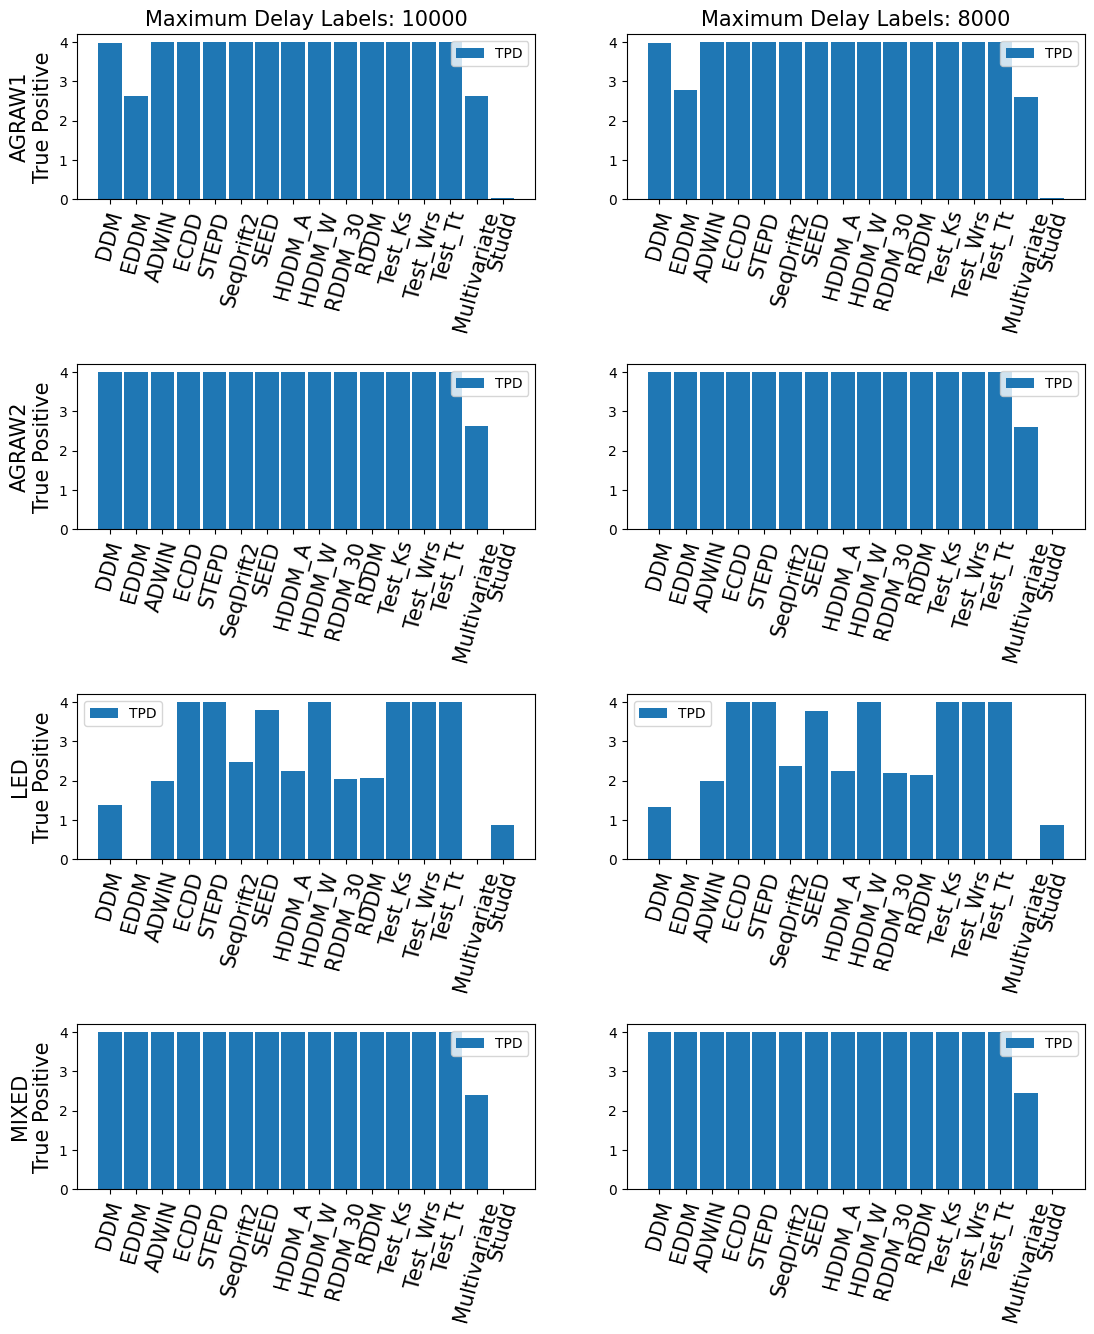

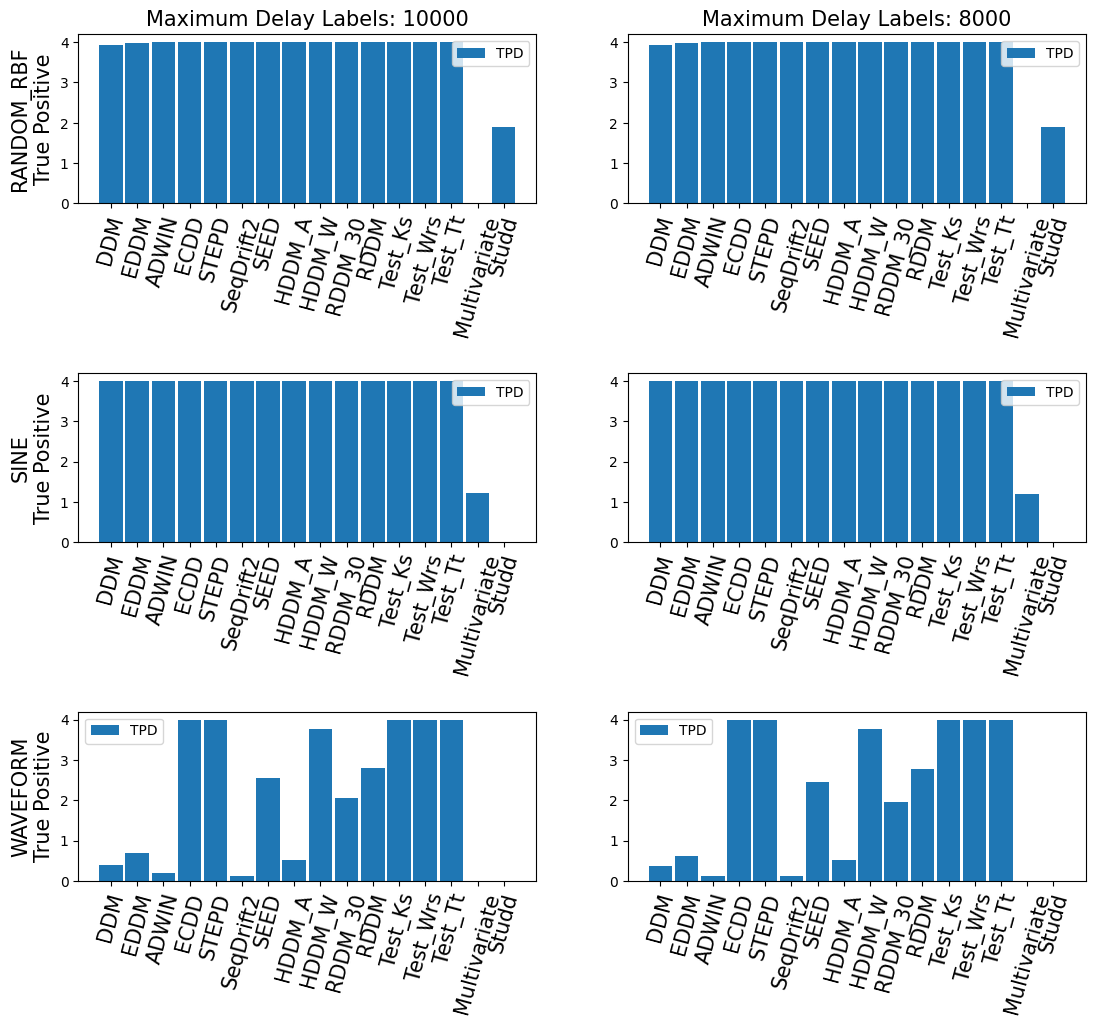

In [9]:
type_drift = "Abrupt"
drift_size = 100000
#partialy_drift options: 95, 96, 97, 98, 99
delay_labeled = [10000, 8000]
#metric name options: detected changes, detected warnings, delay detection (average), delay true detection (average), MTFA (average), MDR, true changes detected, 

metric_name = "true changes detected"
metric_name_label = "True Positive"

label_bar = "TPD"

fig_size_1 = (13,15)
fig_size_2 = (13,11)

df = pd.read_csv(f'../results/delay/csv_aggregation/{type_drift}_{metric_name}_{drift_size}.csv')
data_sets_v1 = ['AGRAW1', 'AGRAW2', 'LED', 'MIXED']
data_sets_v2 = ['RANDOM_RBF', 'SINE', 'WAVEFORM']

generate_bar_plot_metric(df, data_sets_v1, delay_labeled, metric_name_label, type_drift, drift_size, fig_size_1, label_bar, y_log=False, part=1, folder_name="delay_plots_aggregation_v2")
generate_bar_plot_metric(df, data_sets_v2, delay_labeled, metric_name_label, type_drift, drift_size, fig_size_2, label_bar, y_log=False, part=2, folder_name="delay_plots_aggregation_v2")


## Abrupt Drift and Delay Labeled Data Stream 1k, 2k, 4k (TPD)

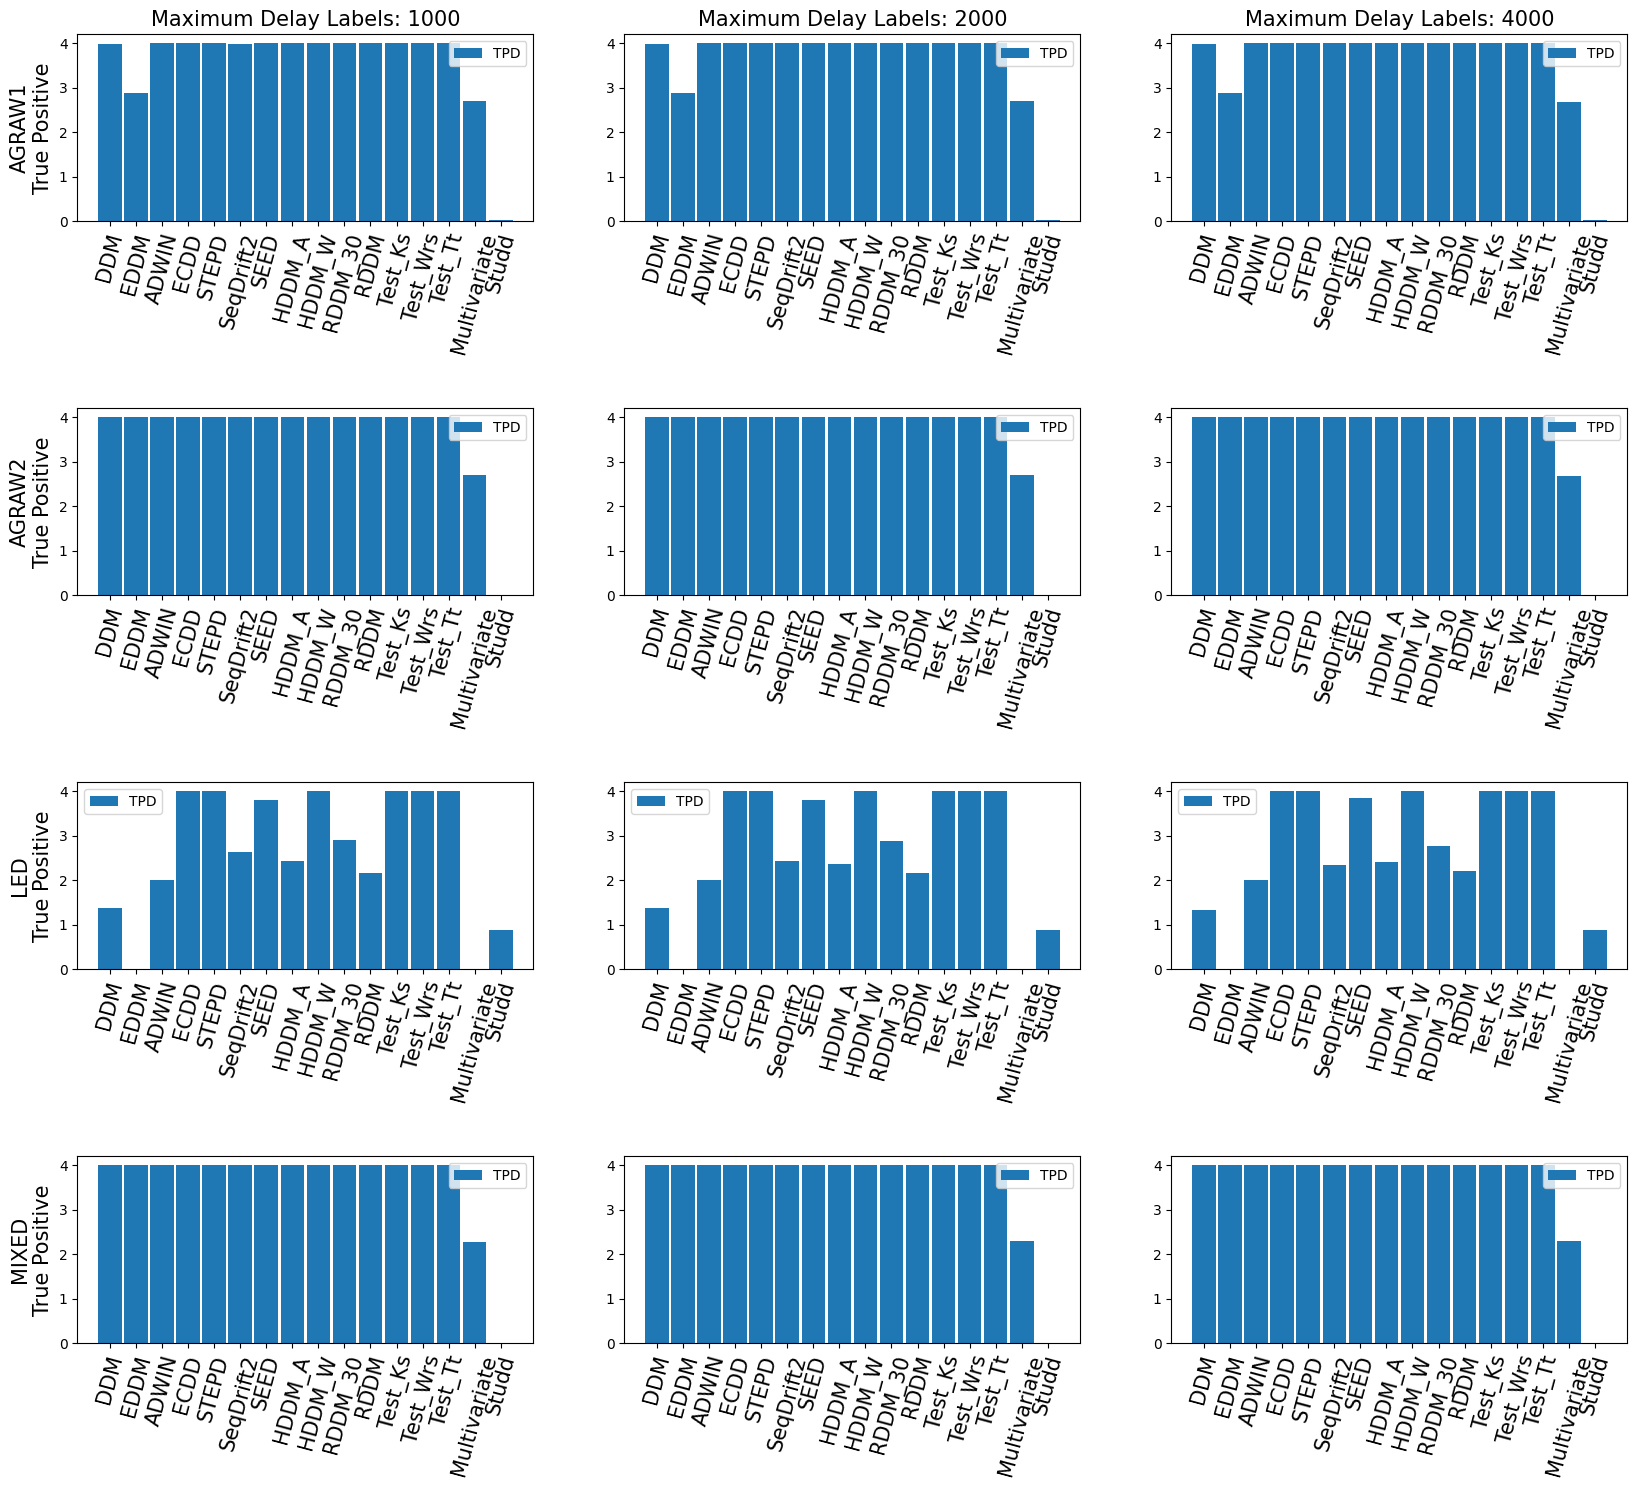

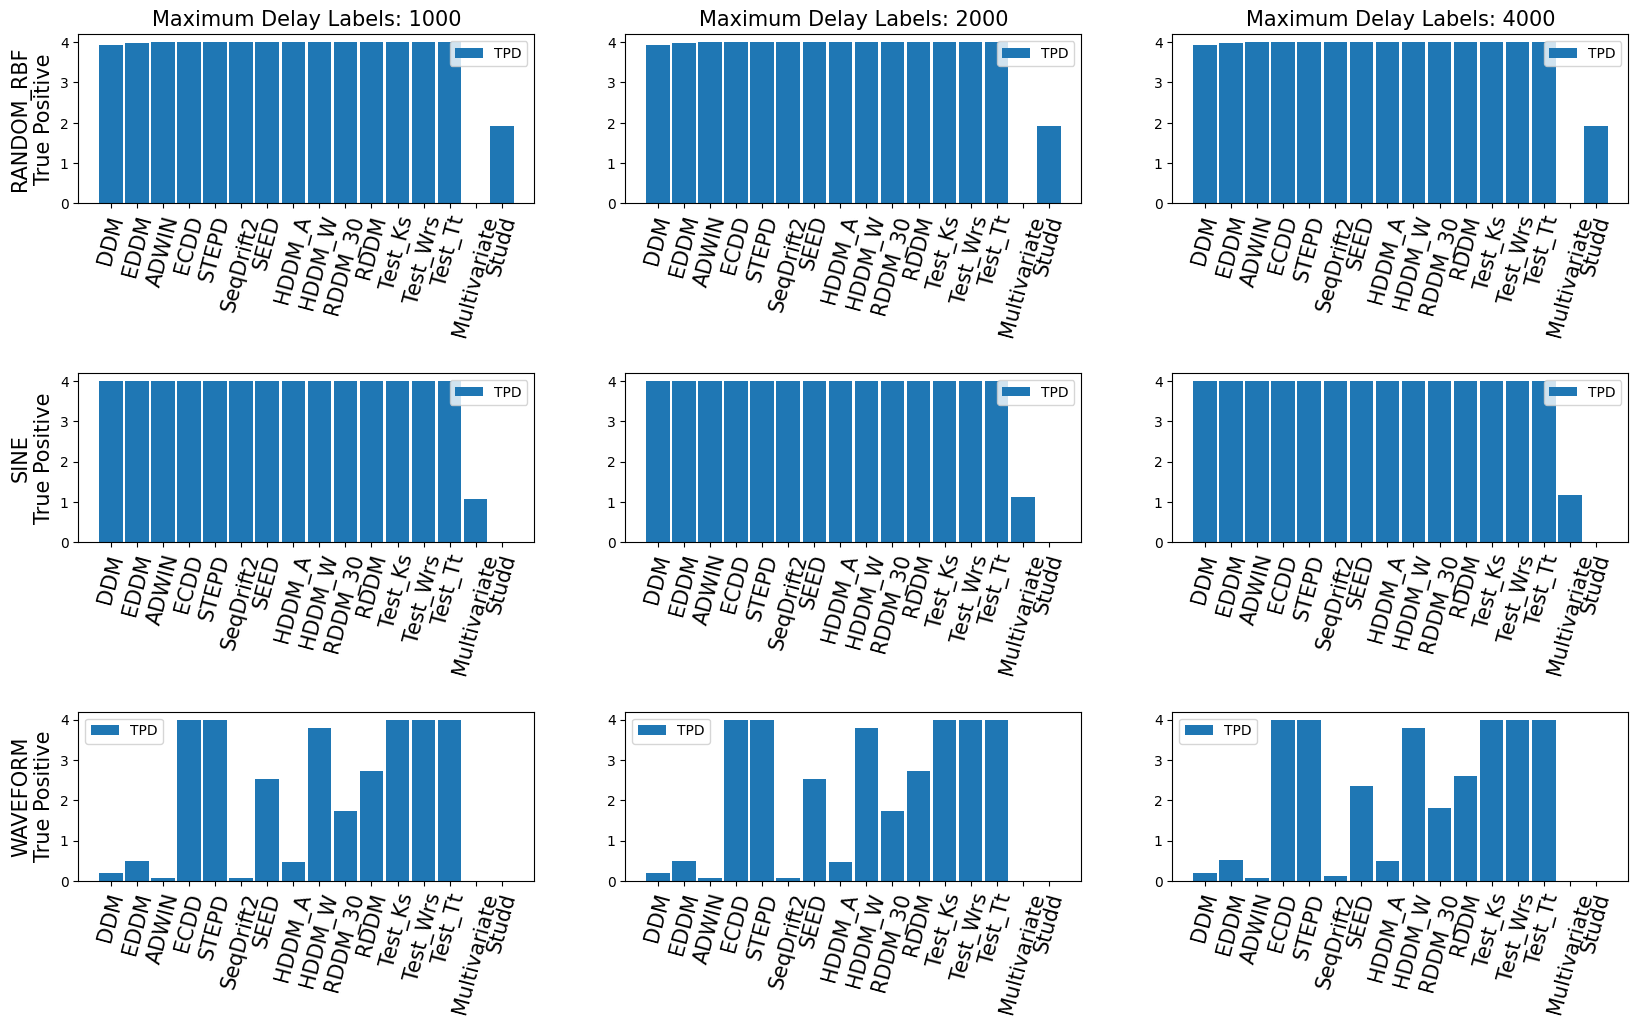

In [11]:
type_drift = "Abrupt"
metric_name = "true changes detected"
metric_name_label = "True Positive"
label_bar = "TPD"
drift_size = 100000

delay_labeled = [1000, 2000, 4000]

fig_size_1 = (20,17)
fig_size_2 = (20,11)

df = pd.read_csv(f'../results/delay/csv_aggregation/{type_drift}_{metric_name}_{drift_size}.csv')
data_sets_v1 = ['AGRAW1', 'AGRAW2', 'LED', 'MIXED']
data_sets_v2 = ['RANDOM_RBF', 'SINE', 'WAVEFORM']

generate_bar_plot_metric(df, data_sets_v1, delay_labeled, metric_name_label, type_drift, drift_size, fig_size_1, label_bar, y_log=False, part=1, folder_name="delay_plots_aggregation_v2")
generate_bar_plot_metric(df, data_sets_v2, delay_labeled, metric_name_label, type_drift, drift_size, fig_size_2, label_bar, y_log=False, part=2, folder_name="delay_plots_aggregation_v2")


## Gradual Drift and Delay Labeled Data Stream 1k, 2k, 4k (TPD)

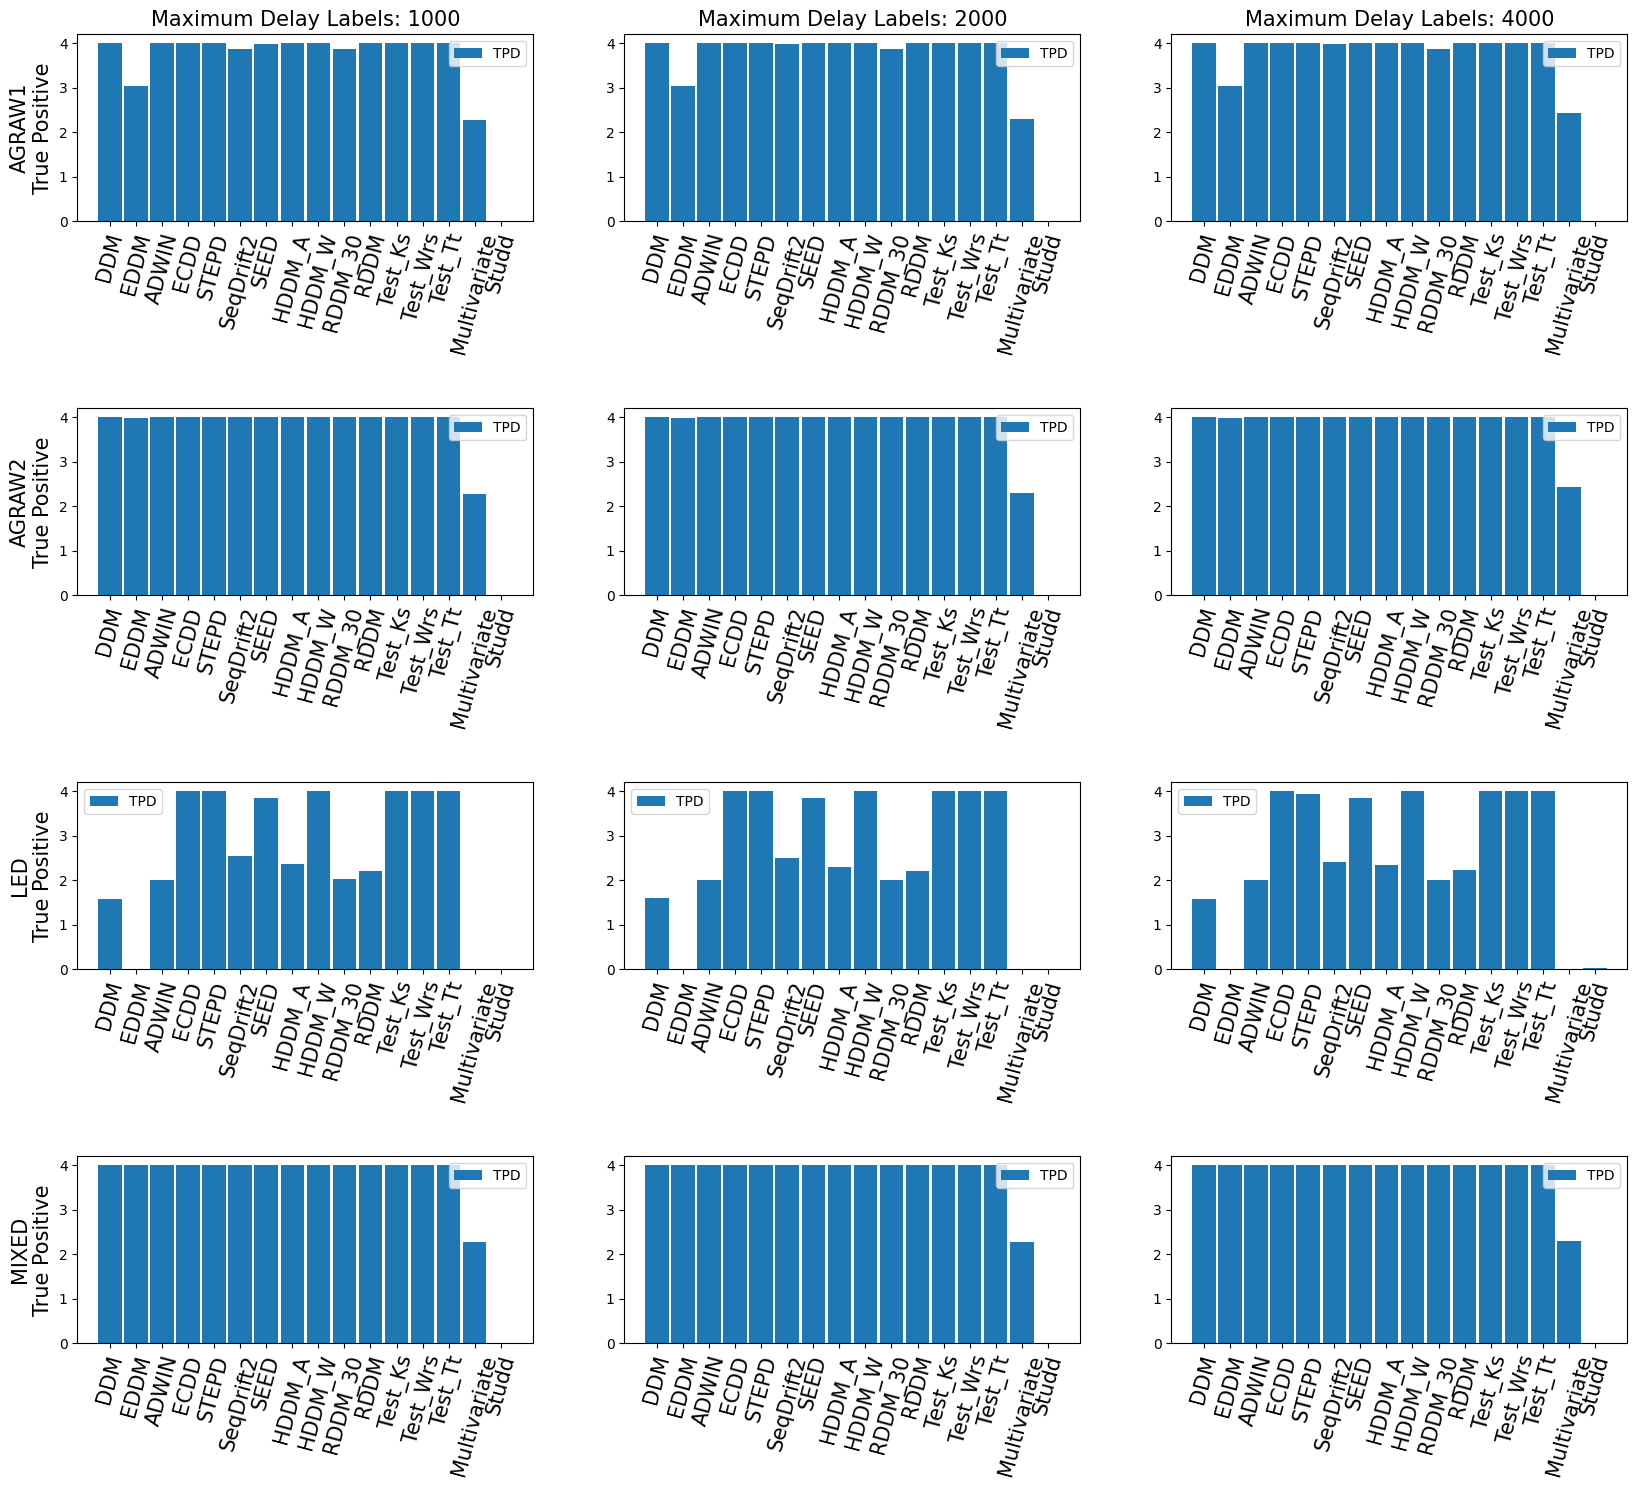

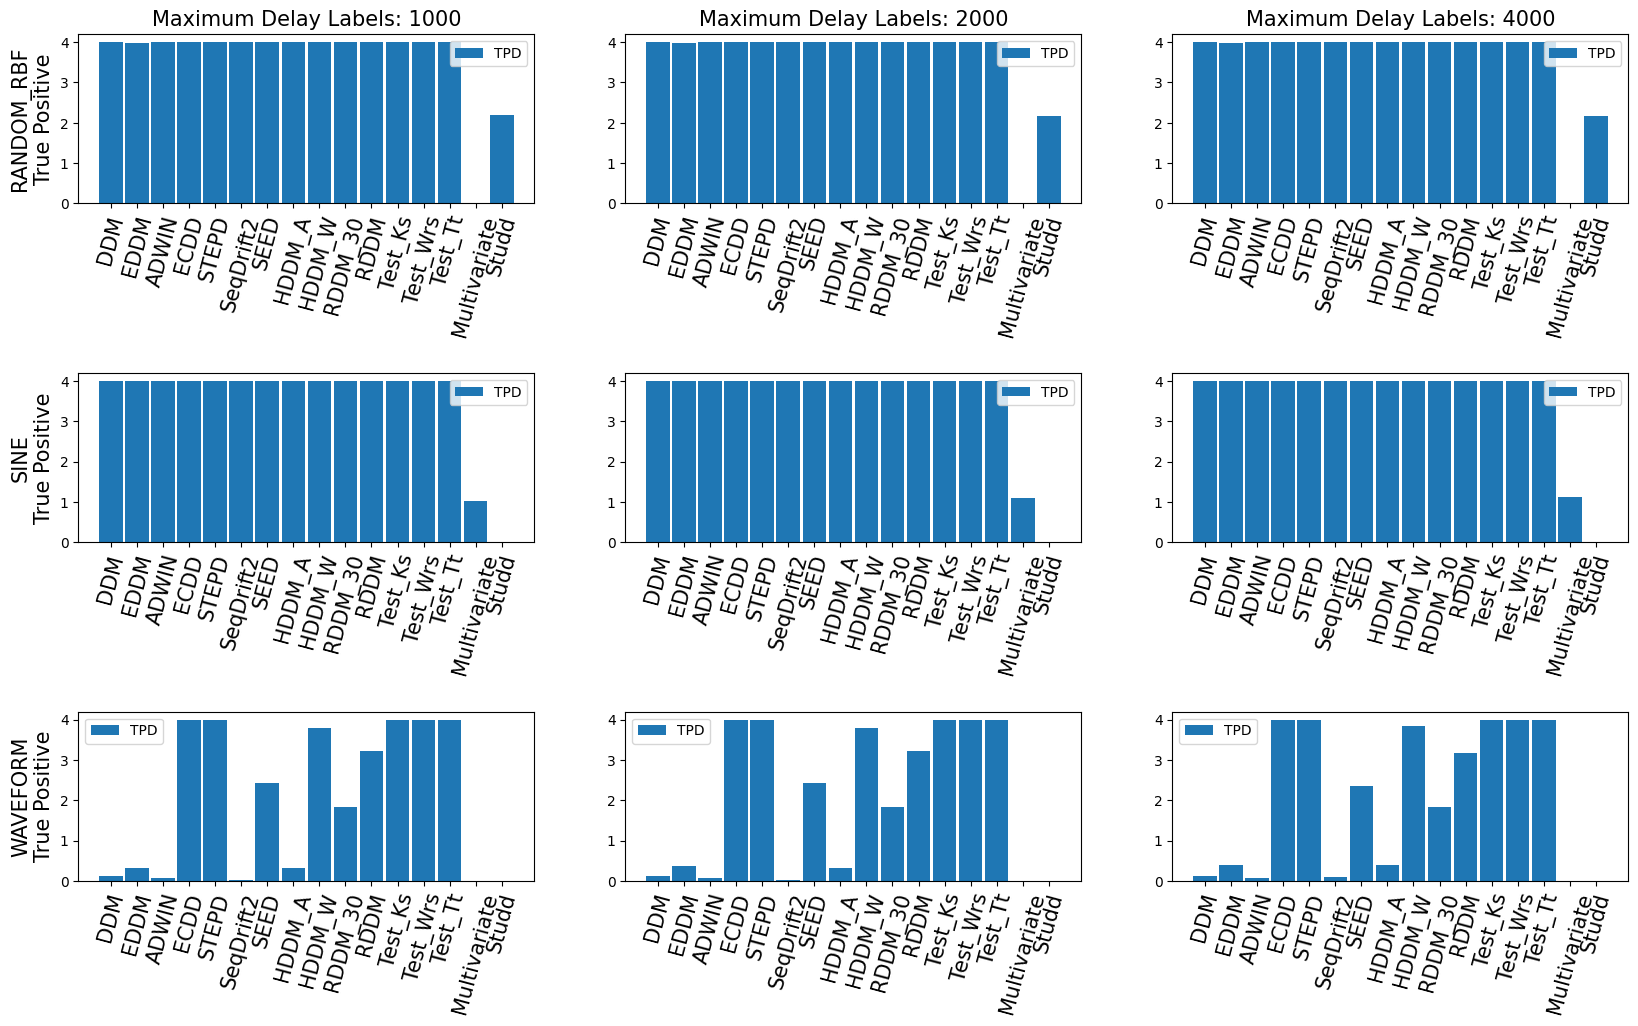

In [12]:
drift_size = 100000
#partialy_drift options: 95, 96, 97, 98, 99
delay_labeled = [1000, 2000, 4000]
type_drift = "Gradual"
#metric name options: detected changes, detected warnings, delay detection (average), delay true detection (average), MTFA (average), MDR, true changes detected, 
metric_name = "true changes detected"
metric_name_label = "True Positive"
label_bar = "TPD"

df = pd.read_csv(f'../results/delay/csv_aggregation/{type_drift}_{metric_name}_{drift_size}.csv')
data_sets_v1 = ['AGRAW1', 'AGRAW2', 'LED', 'MIXED']
data_sets_v2 = ['RANDOM_RBF', 'SINE', 'WAVEFORM']

fig_size_1 = (20,17)
fig_size_2 = (20,11)

generate_bar_plot_metric(df, data_sets_v1, delay_labeled, metric_name_label, type_drift, drift_size, fig_size_1, label_bar, y_log=False, part=1, folder_name="delay_plots_aggregation_v2")
generate_bar_plot_metric(df, data_sets_v2, delay_labeled, metric_name_label, type_drift, drift_size, fig_size_2, label_bar, y_log=False, part=2, folder_name="delay_plots_aggregation_v2")


## Gradual Drift and Delay Labeled Data Stream 10k, 8k (TPD)

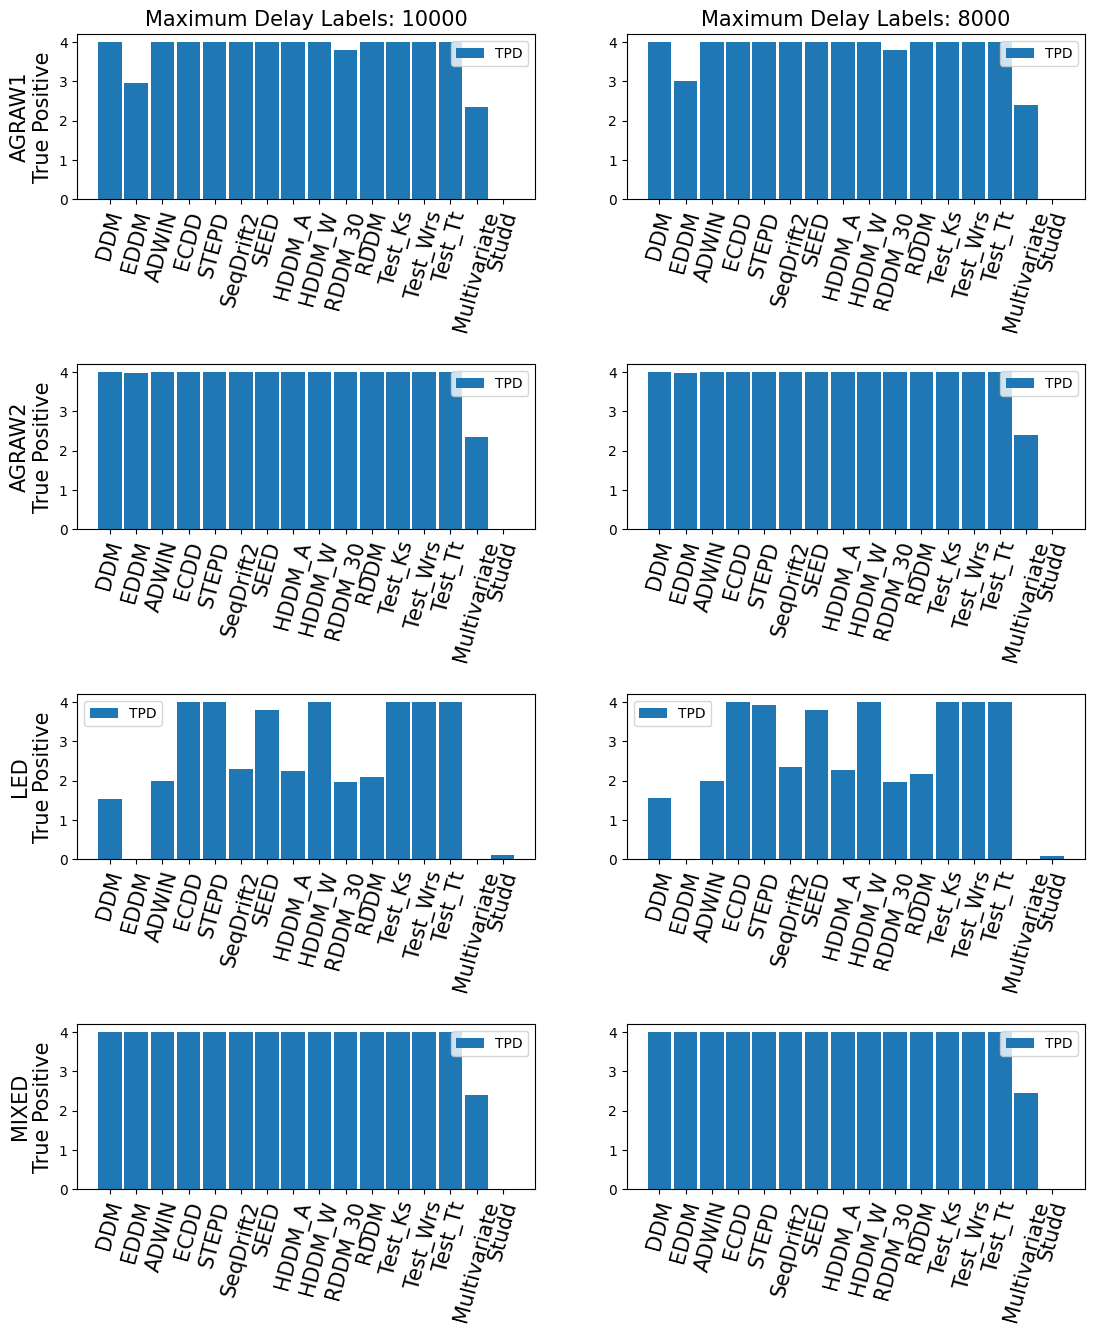

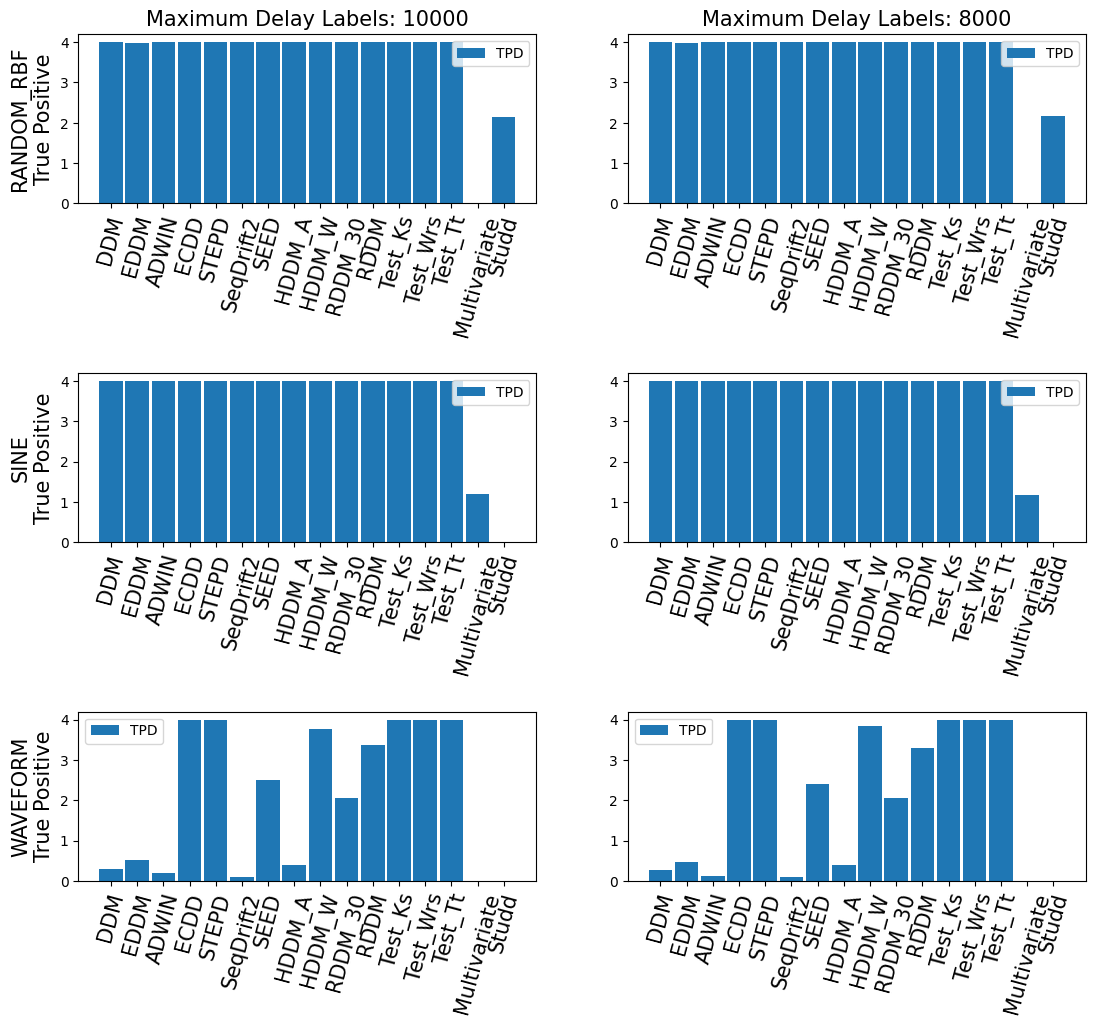

In [13]:
drift_size = 100000
#partialy_drift options: 95, 96, 97, 98, 99
delay_labeled = [10000, 8000]
type_drift = "Gradual"
#metric name options: detected changes, detected warnings, delay detection (average), delay true detection (average), MTFA (average), MDR, true changes detected, 
metric_name = "true changes detected"
metric_name_label = "True Positive"
label_bar = "TPD"
df = pd.read_csv(f'../results/delay/csv_aggregation/{type_drift}_{metric_name}_{drift_size}.csv')

data_sets_v1 = ['AGRAW1', 'AGRAW2', 'LED', 'MIXED']
data_sets_v2 = ['RANDOM_RBF', 'SINE', 'WAVEFORM']

fig_size_1 = (13,15)
fig_size_2 = (13,11)

generate_bar_plot_metric(df, data_sets_v1, delay_labeled, metric_name_label, type_drift, drift_size, fig_size_1, label_bar, y_log=False, part=1, folder_name="delay_plots_aggregation_v2")
generate_bar_plot_metric(df, data_sets_v2, delay_labeled, metric_name_label, type_drift, drift_size, fig_size_2, label_bar, y_log=False, part=2, folder_name="delay_plots_aggregation_v2")

## Abrupt Drift and Delay Labeled Data Stream 10k, 8k (TDD)

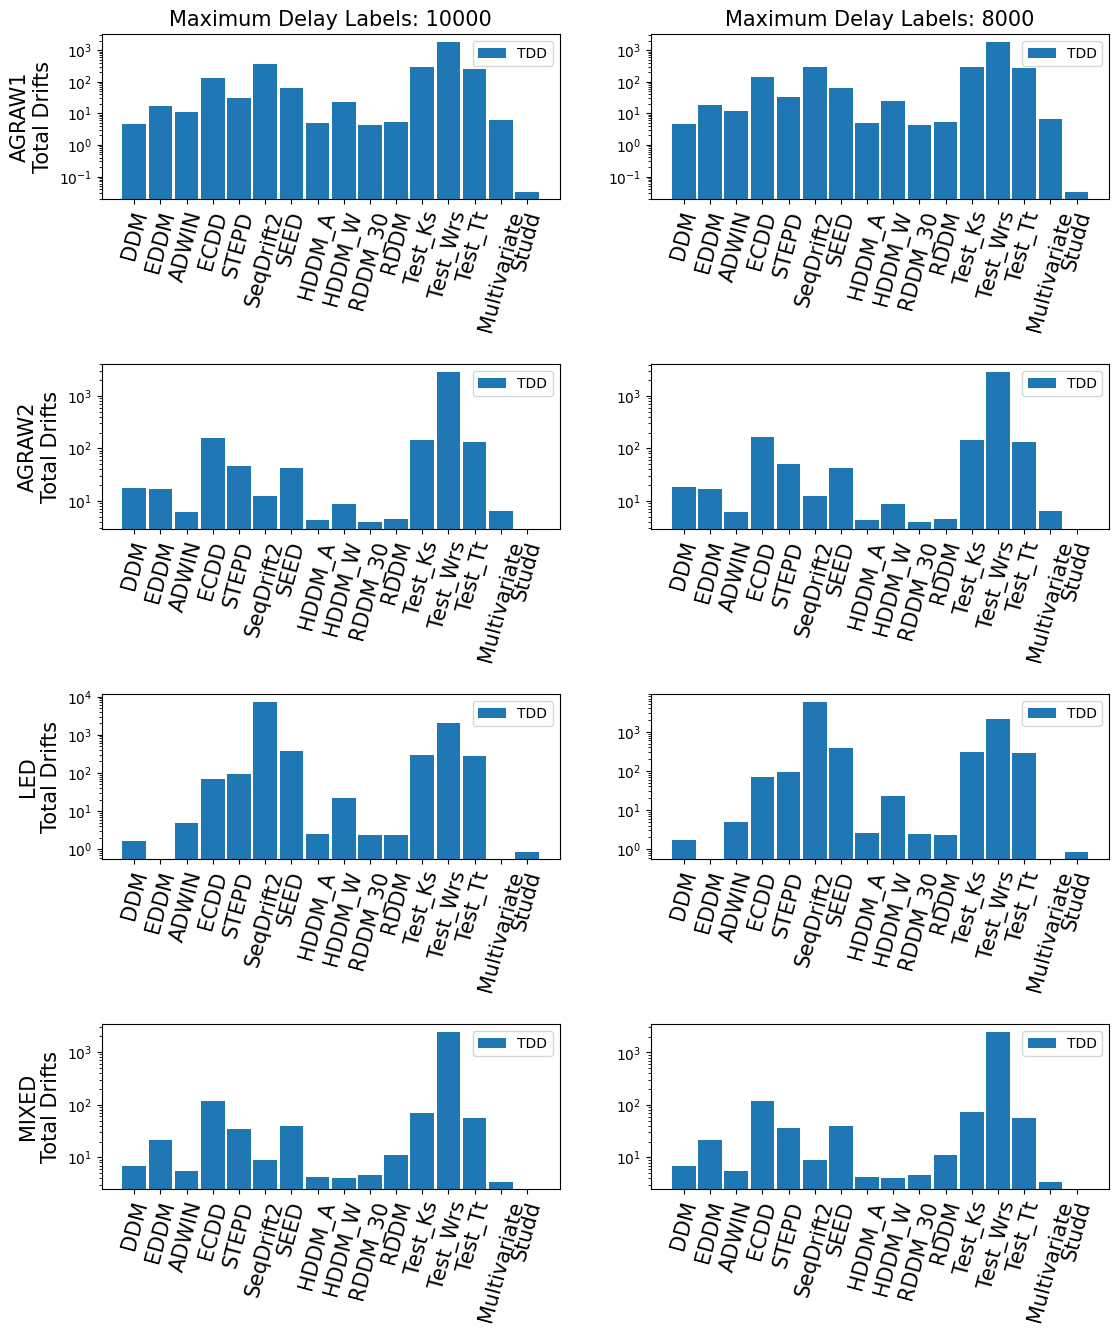

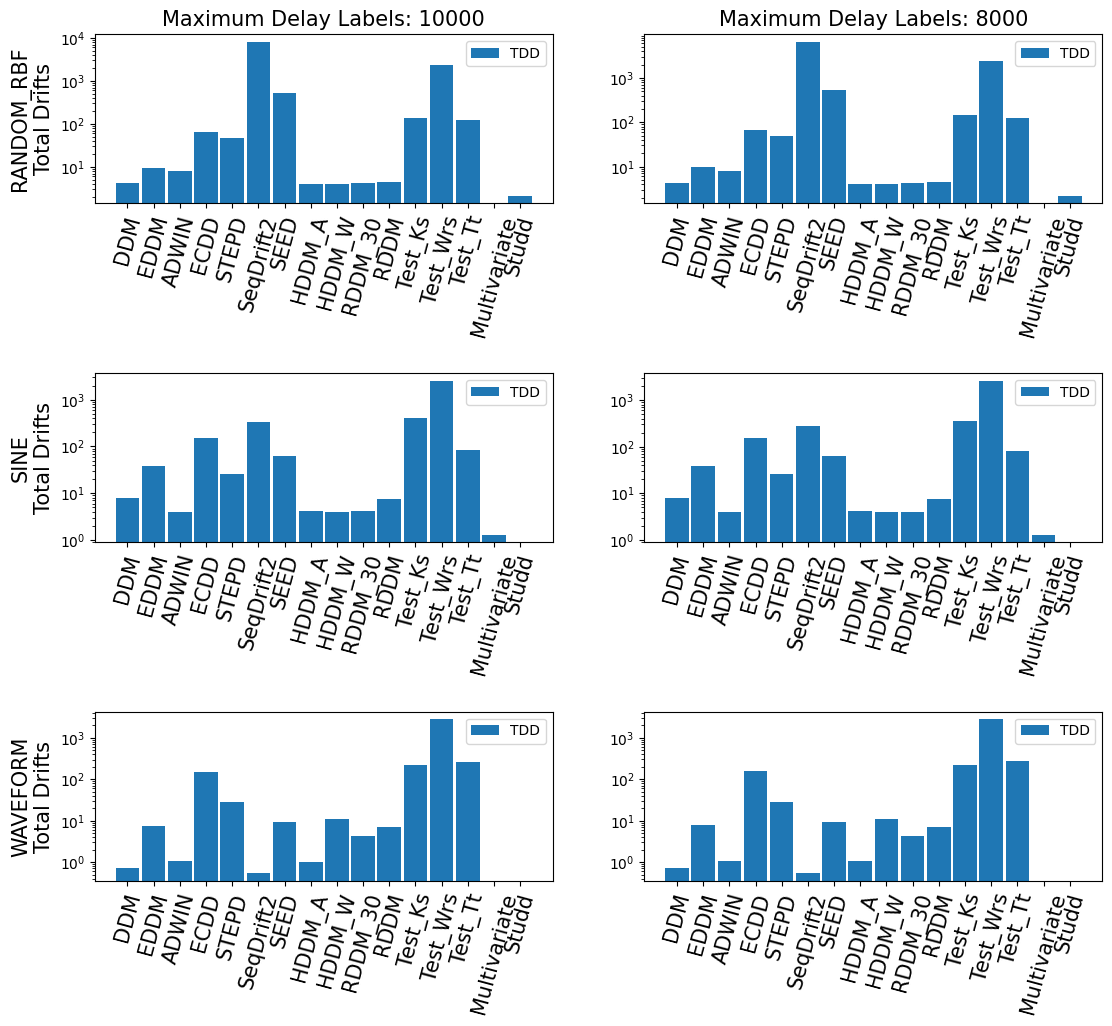

In [15]:
drift_size = 100000
#partialy_drift options: 95, 96, 97, 98, 99
delay_labeled = [10000, 8000]
type_drift = "Abrupt"
#metric name options: detected changes, detected warnings, delay detection (average), delay true detection (average), MTFA (average), MDR, true changes detected, 
metric_name = "detected changes"
metric_name_label = "Total Drifts"
label_bar = "TDD"
df = pd.read_csv(f'../results/delay/csv_aggregation/{type_drift}_{metric_name}_{drift_size}.csv')

data_sets_v1 = ['AGRAW1', 'AGRAW2', 'LED', 'MIXED']
data_sets_v2 = ['RANDOM_RBF', 'SINE', 'WAVEFORM']

fig_size_1 = (13,15)
fig_size_2 = (13,11)

generate_bar_plot_metric(df, data_sets_v1, delay_labeled, metric_name_label, type_drift, drift_size, fig_size_1, label_bar, y_log=True, part=1, folder_name="delay_plots_aggregation_v2")
generate_bar_plot_metric(df, data_sets_v2, delay_labeled, metric_name_label, type_drift, drift_size, fig_size_2, label_bar, y_log=True, part=2, folder_name="delay_plots_aggregation_v2")

## Abrupt Drift and Delay Labeled Data Stream 1k, 2k, 4k (TDD)

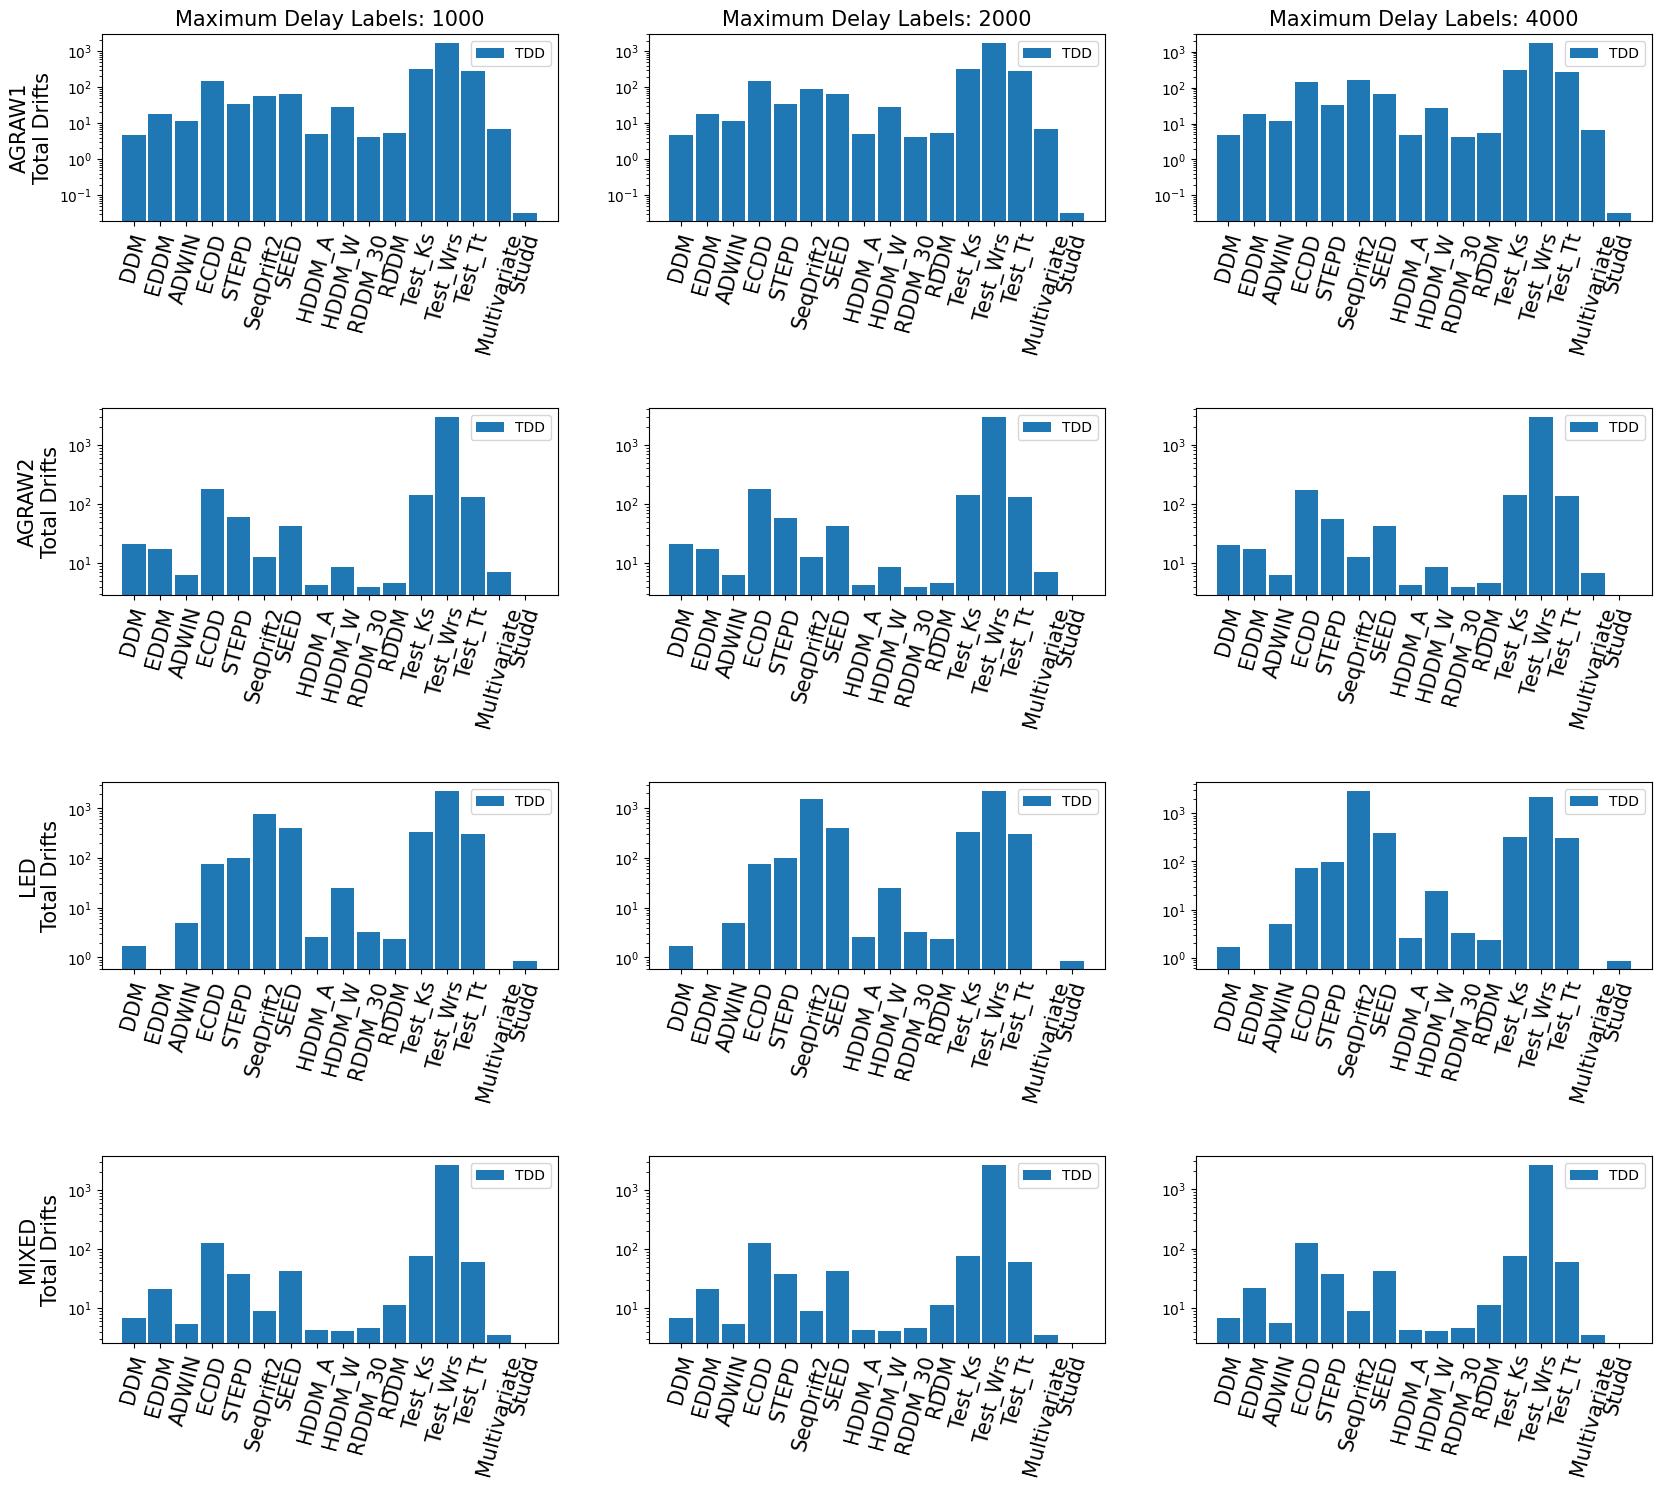

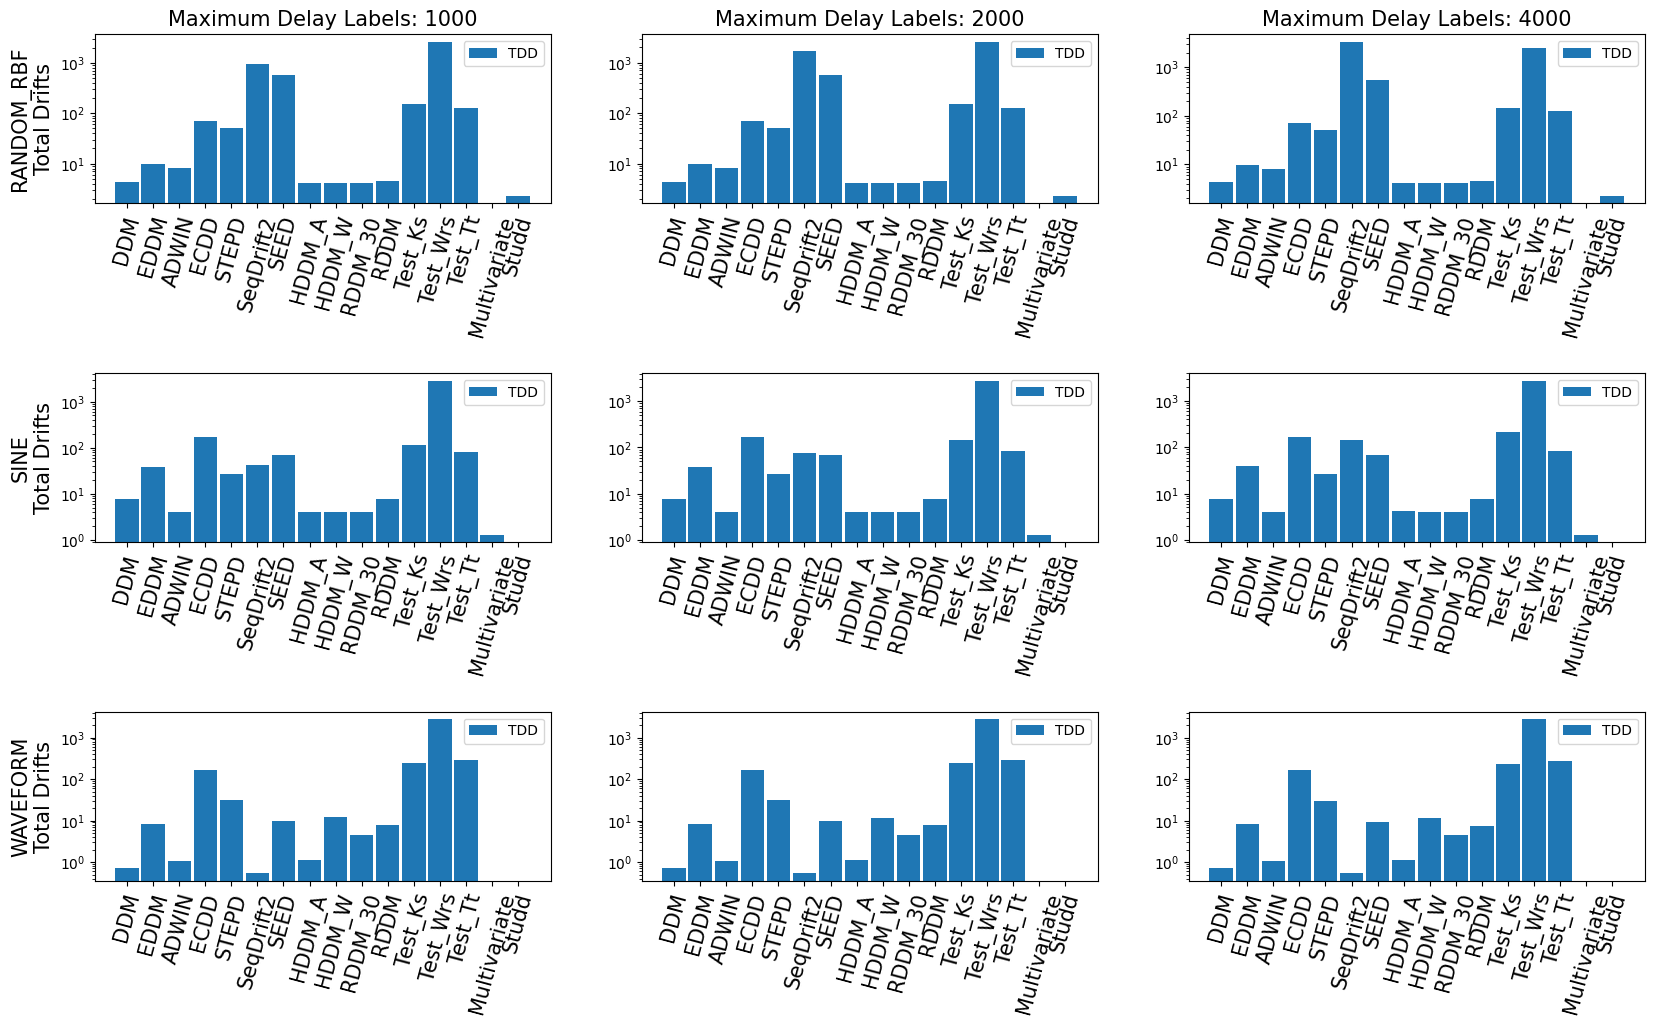

In [16]:
drift_size = 100000
#partialy_drift options: 95, 96, 97, 98, 99
delay_labeled = [1000, 2000, 4000]
type_drift = "Abrupt"
#metric name options: detected changes, detected warnings, delay detection (average), delay true detection (average), MTFA (average), MDR, true changes detected, 
metric_name = "detected changes"
metric_name_label = "Total Drifts"
label_bar = "TDD"
df = pd.read_csv(f'../results/delay/csv_aggregation/{type_drift}_{metric_name}_{drift_size}.csv')

data_sets_v1 = ['AGRAW1', 'AGRAW2', 'LED', 'MIXED']
data_sets_v2 = ['RANDOM_RBF', 'SINE', 'WAVEFORM']

fig_size_1 = (20,17)
fig_size_2 = (20,11)

generate_bar_plot_metric(df, data_sets_v1, delay_labeled, metric_name_label, type_drift, drift_size, fig_size_1, label_bar, y_log=True, part=1, folder_name="delay_plots_aggregation_v2")
generate_bar_plot_metric(df, data_sets_v2, delay_labeled, metric_name_label, type_drift, drift_size, fig_size_2, label_bar, y_log=True, part=2, folder_name="delay_plots_aggregation_v2")

## Gradual Drift and Partially Labeled Data Stream 1k, 2k, 4k (TDD)

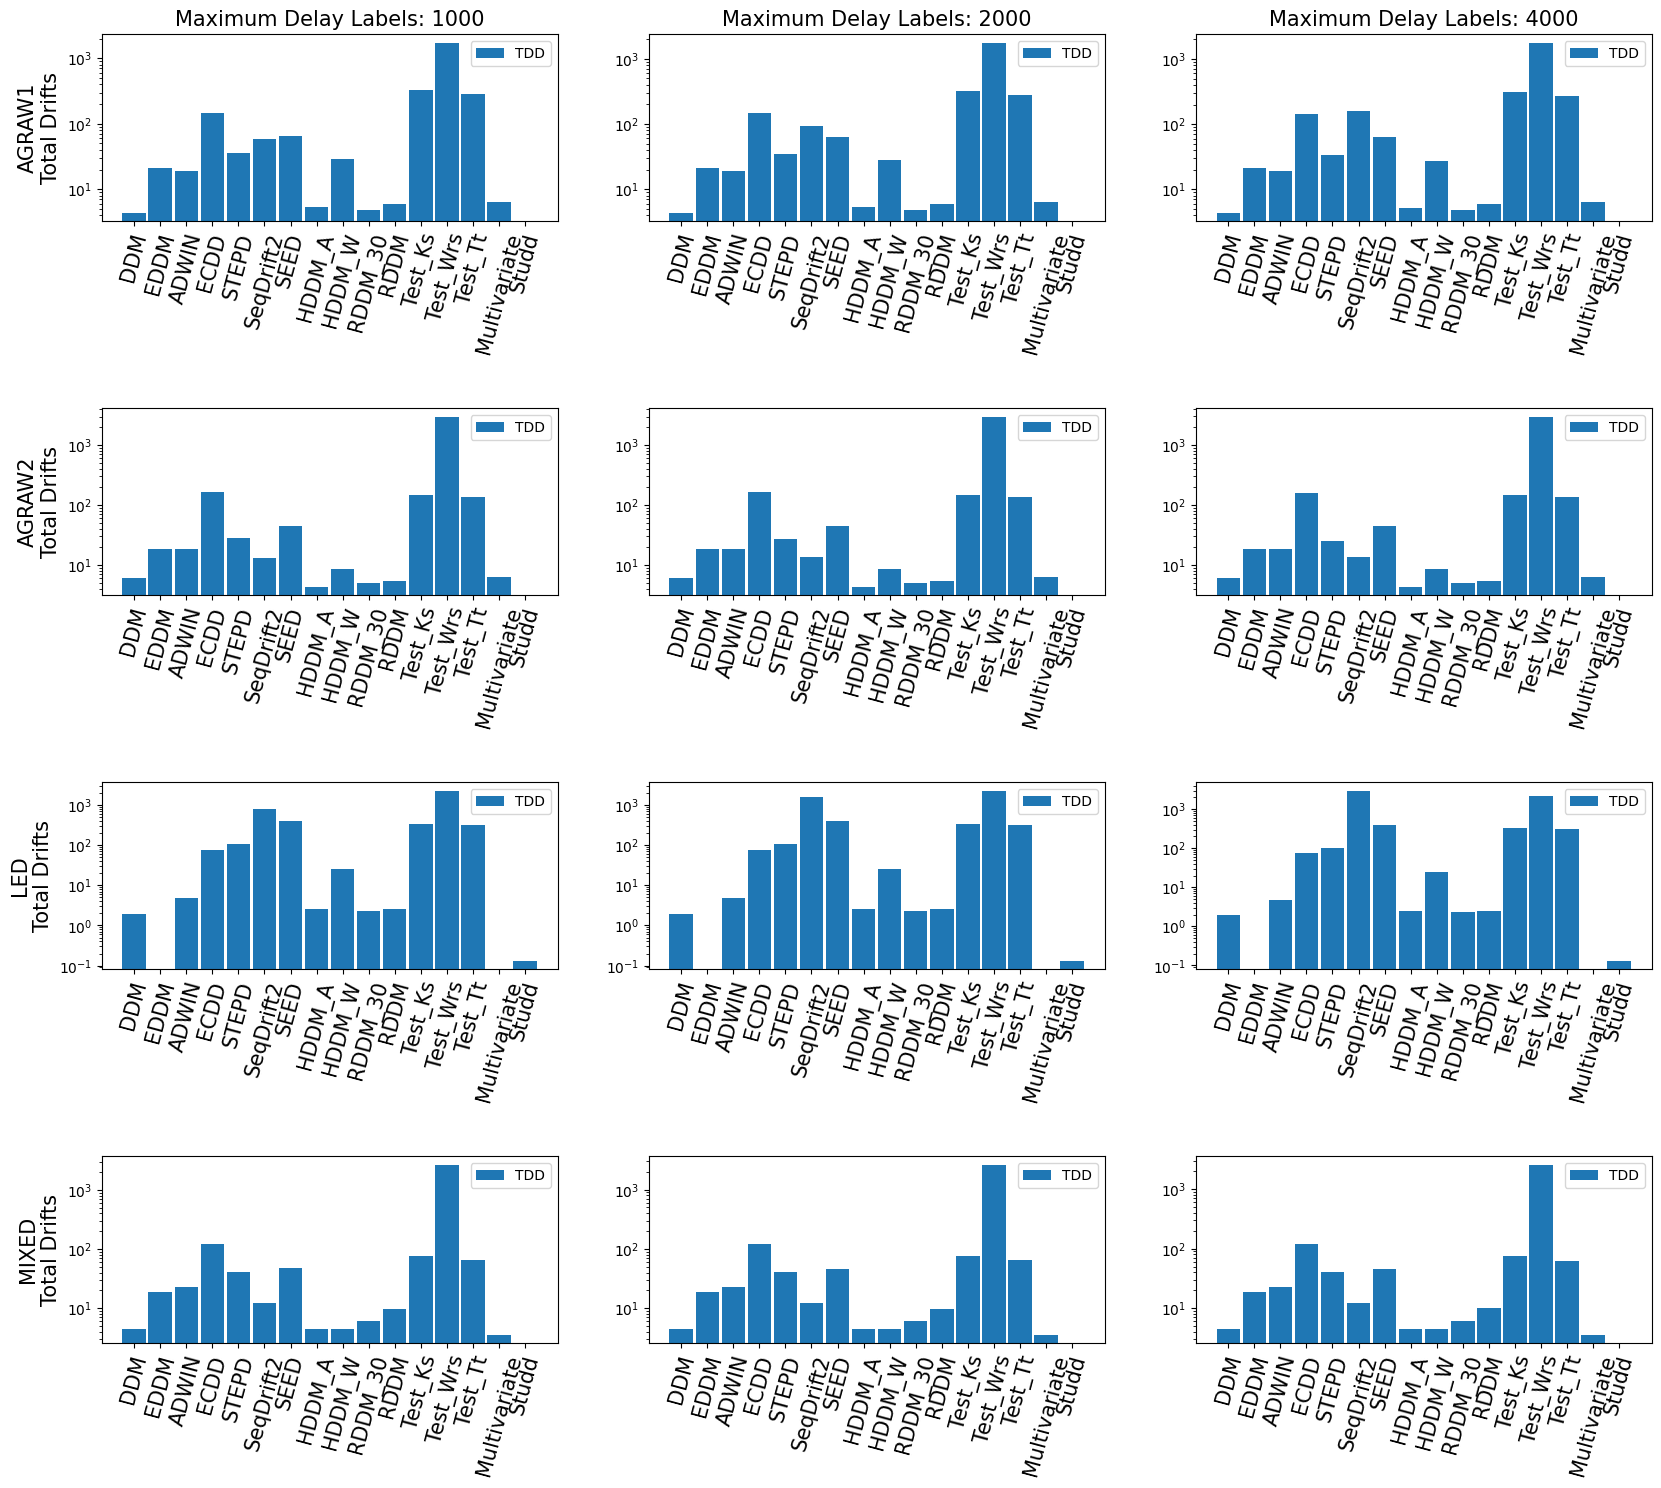

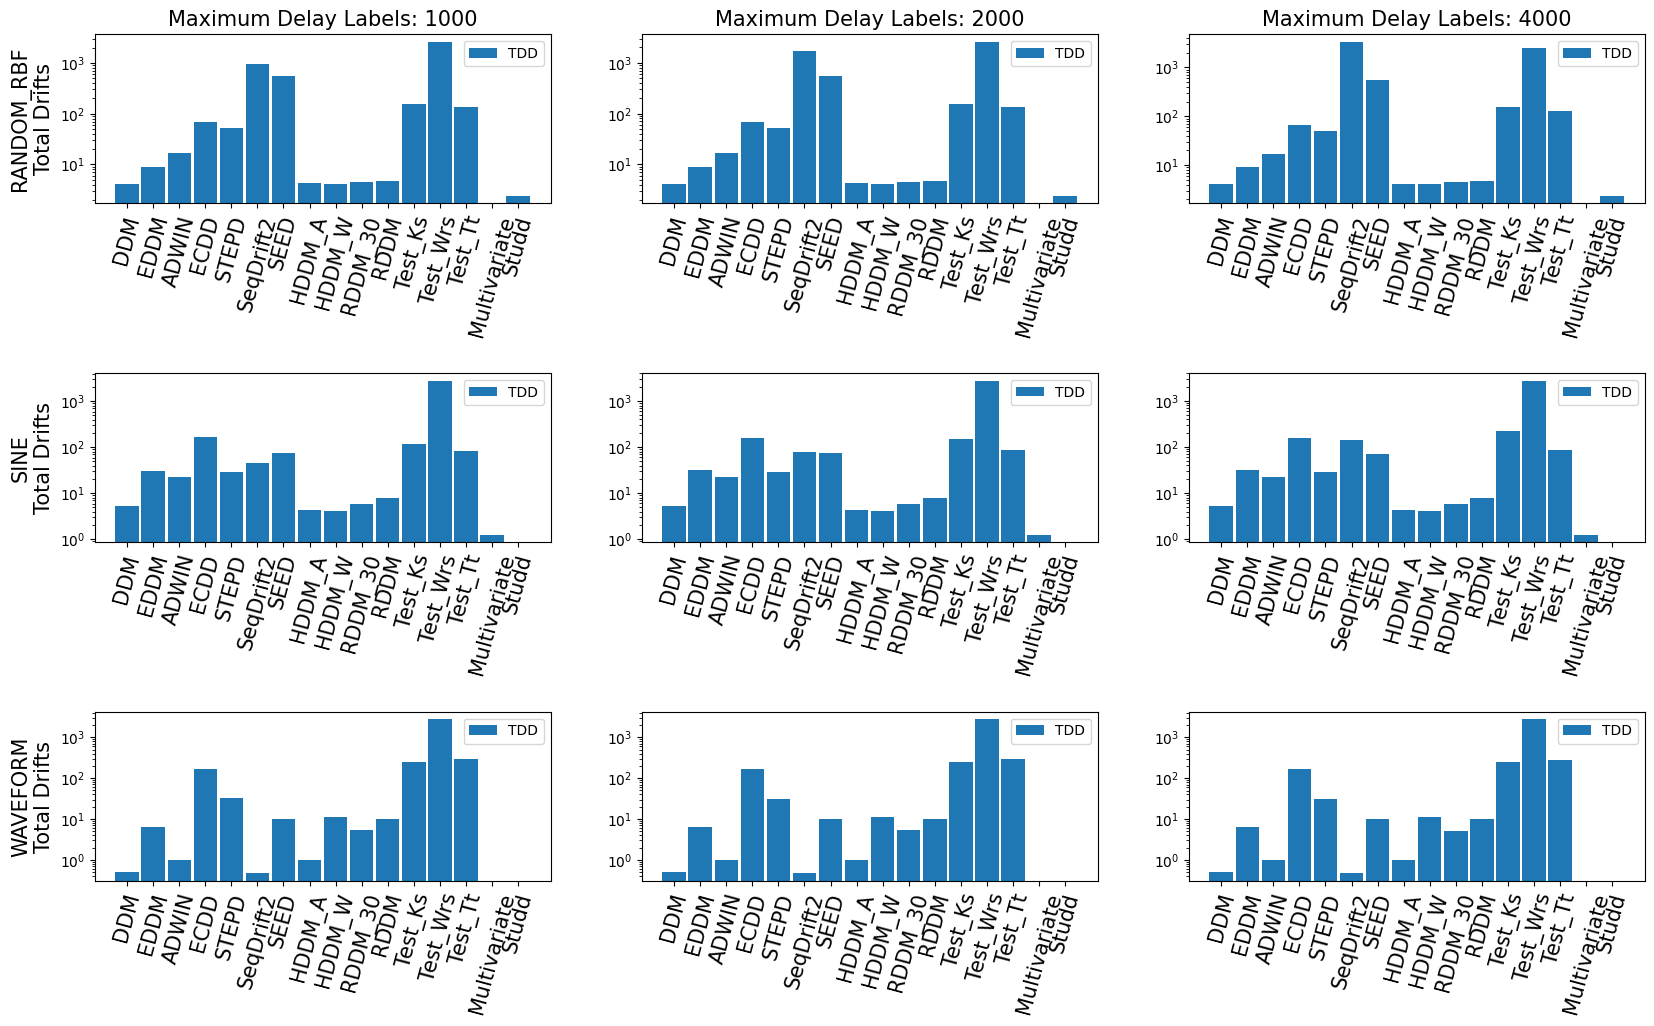

In [17]:
drift_size = 100000
#partialy_drift options: 95, 96, 97, 98, 99
delay_labeled = [1000, 2000, 4000]
type_drift = "Gradual"
#metric name options: detected changes, detected warnings, delay detection (average), delay true detection (average), MTFA (average), MDR, true changes detected, 
metric_name = "detected changes"
metric_name_label = "Total Drifts"
label_bar = "TDD"
df = pd.read_csv(f'../results/delay/csv_aggregation/{type_drift}_{metric_name}_{drift_size}.csv')

data_sets_v1 = ['AGRAW1', 'AGRAW2', 'LED', 'MIXED']
data_sets_v2 = ['RANDOM_RBF', 'SINE', 'WAVEFORM']

fig_size_1 = (20,17)
fig_size_2 = (20,11)

generate_bar_plot_metric(df, data_sets_v1, delay_labeled, metric_name_label, type_drift, drift_size, fig_size_1, label_bar, y_log=True, part=1, folder_name="delay_plots_aggregation_v2")
generate_bar_plot_metric(df, data_sets_v2, delay_labeled, metric_name_label, type_drift, drift_size, fig_size_2, label_bar, y_log=True, part=2, folder_name="delay_plots_aggregation_v2")

## Gradual Drift and Delay Labeled Data Stream 10k, 8k (TDD)

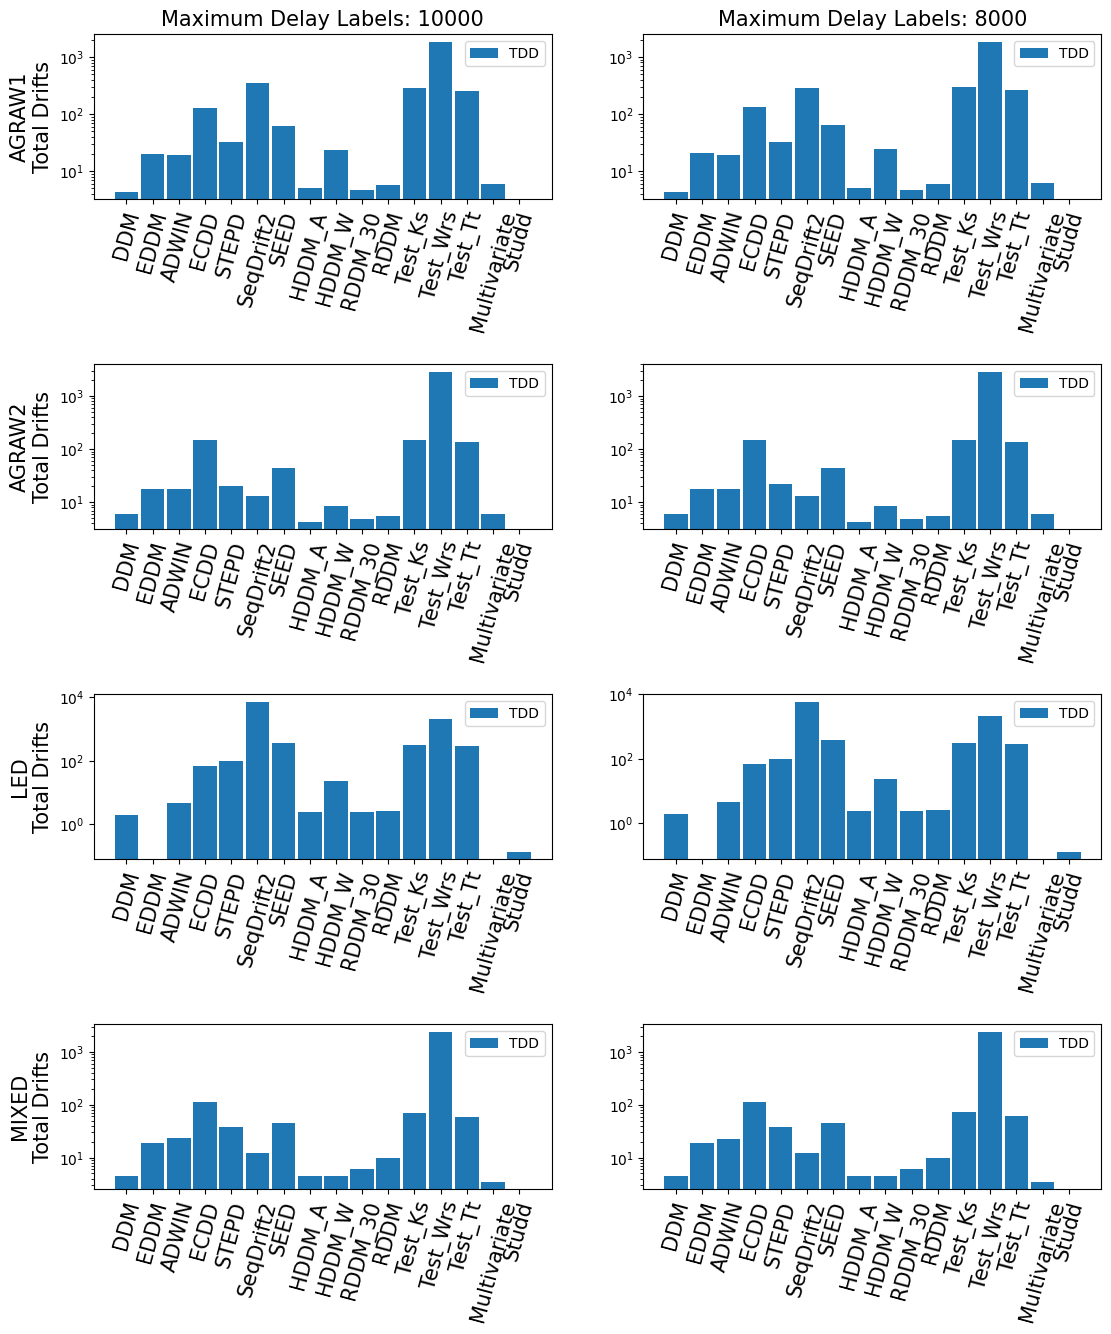

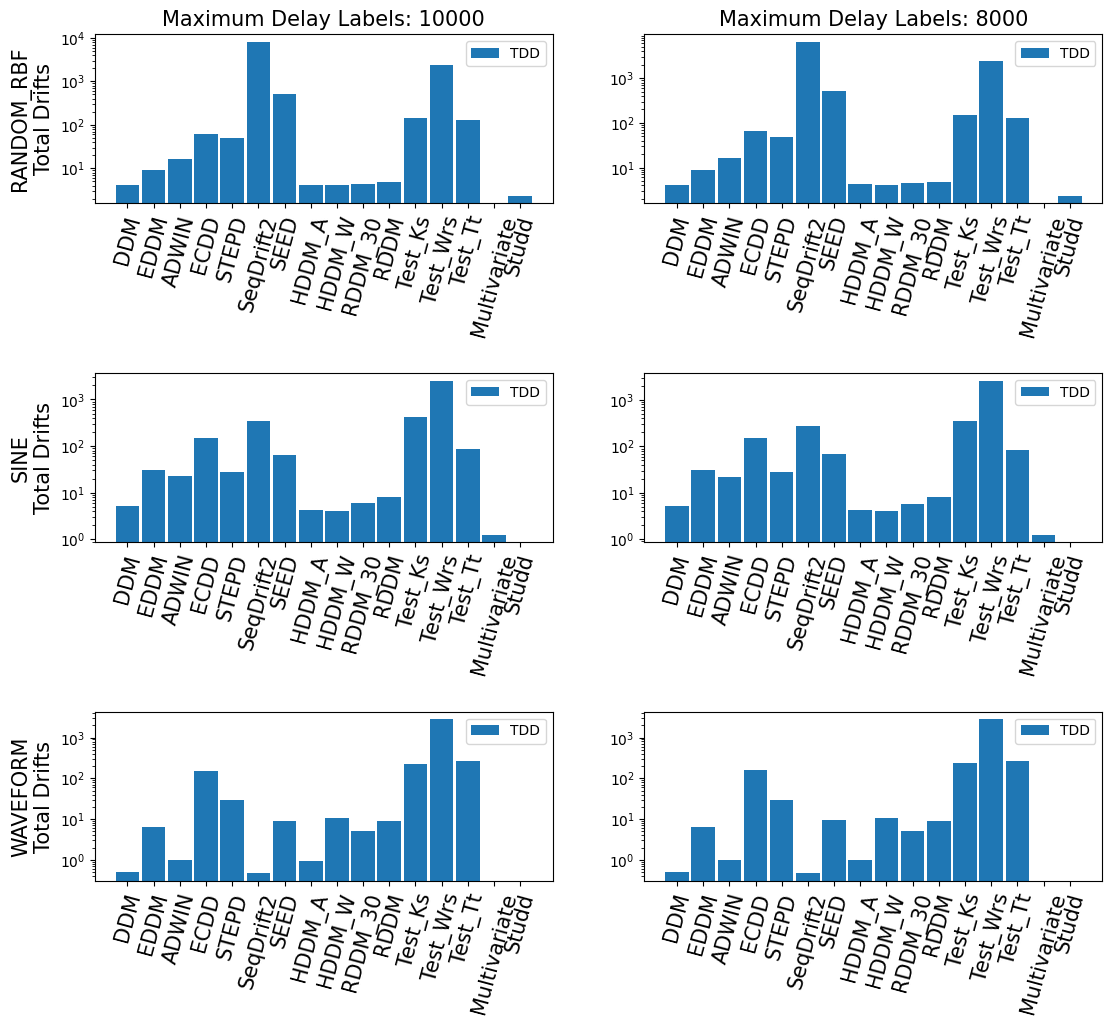

In [18]:
drift_size = 100000
#partialy_drift options: 95, 96, 97, 98, 99
delay_labeled = [10000, 8000]
type_drift = "Gradual"
#metric name options: detected changes, detected warnings, delay detection (average), delay true detection (average), MTFA (average), MDR, true changes detected, 
metric_name = "detected changes"
metric_name_label = "Total Drifts"
label_bar = "TDD"
df = pd.read_csv(f'../results/delay/csv_aggregation/{type_drift}_{metric_name}_{drift_size}.csv')

data_sets_v1 = ['AGRAW1', 'AGRAW2', 'LED', 'MIXED']
data_sets_v2 = ['RANDOM_RBF', 'SINE', 'WAVEFORM']

fig_size_1 = (13,15)
fig_size_2 = (13,11)

generate_bar_plot_metric(df, data_sets_v1, delay_labeled, metric_name_label, type_drift, drift_size, fig_size_1, label_bar, y_log=True, part=1, folder_name="delay_plots_aggregation_v2")
generate_bar_plot_metric(df, data_sets_v2, delay_labeled, metric_name_label, type_drift, drift_size, fig_size_2, label_bar, y_log=True, part=2, folder_name="delay_plots_aggregation_v2")

## Gradual Drift and Delay Labeled Data Stream 10k, 8k (TDDA)

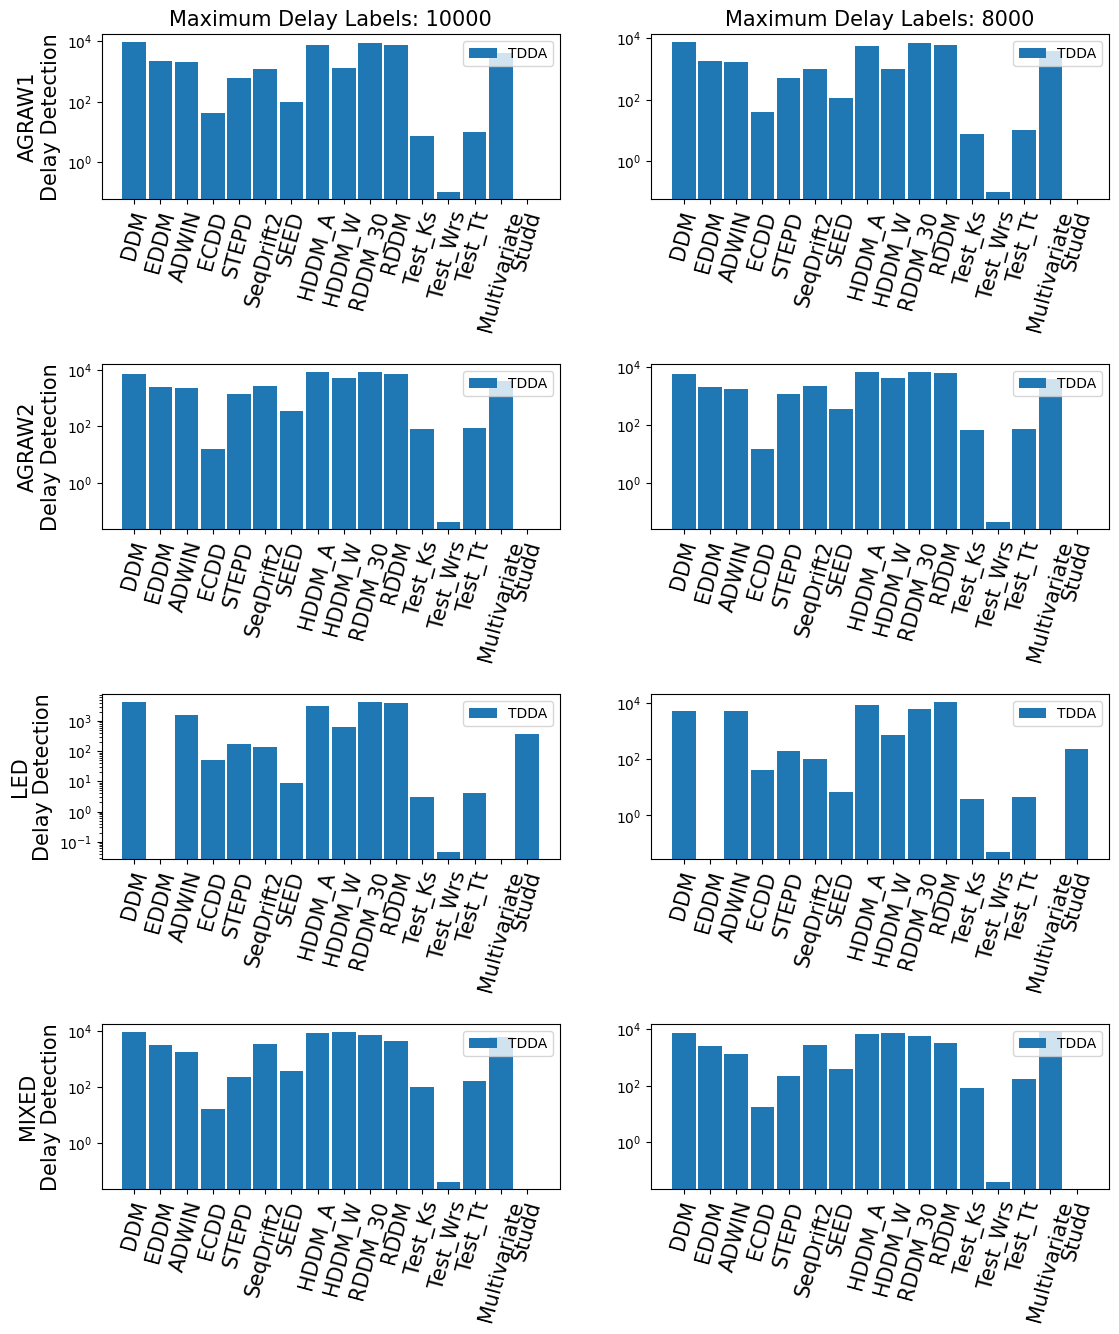

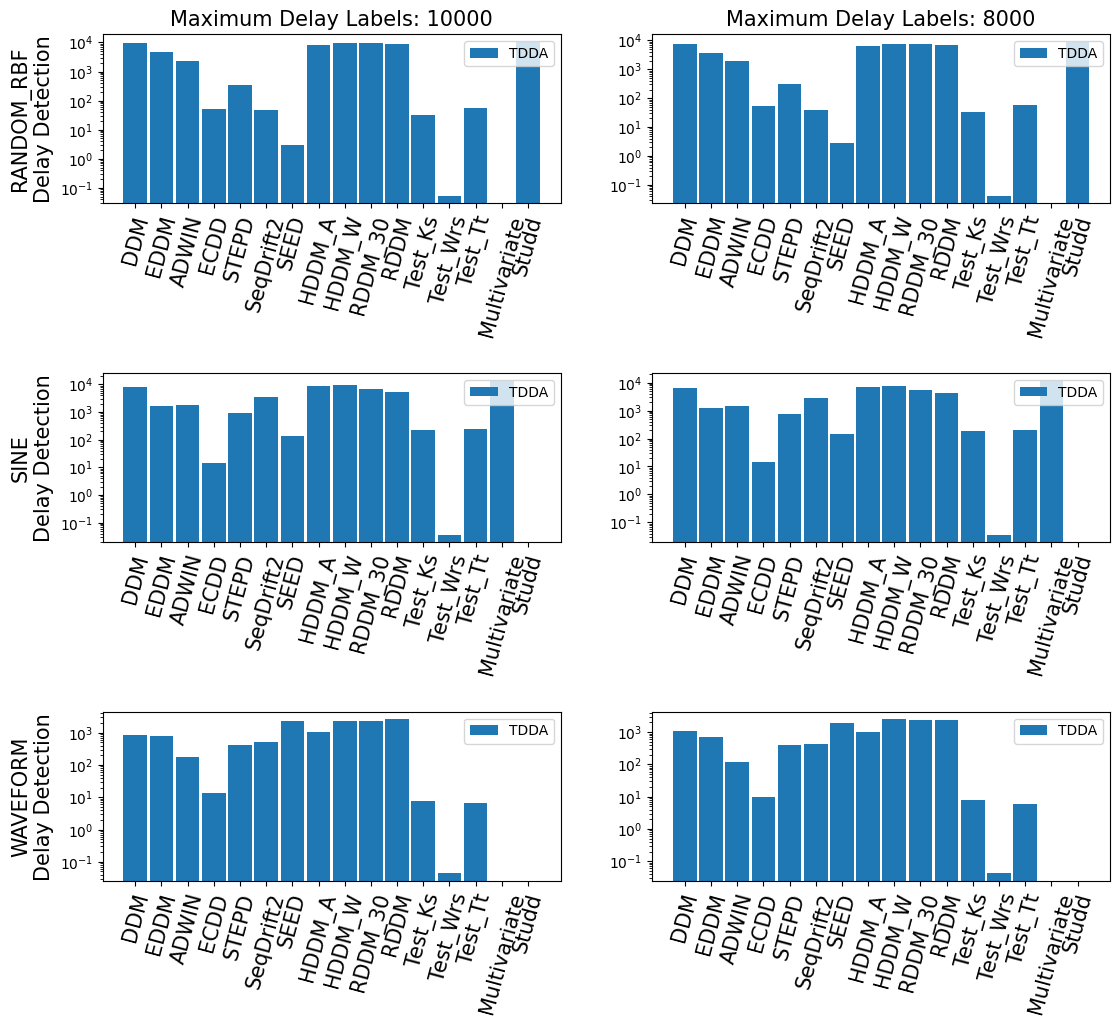

In [19]:
drift_size = 100000
#partialy_drift options: 95, 96, 97, 98, 99
delay_labeled = [10000, 8000]
type_drift = "Gradual"
#metric name options: detected changes, detected warnings, delay detection (average), delay true detection (average), MTFA (average), MDR, true changes detected, 
metric_name = "delay true detection (average)"
metric_name_label = "Delay Detection"
label_bar = "TDDA"
df = pd.read_csv(f'../results/delay/csv_aggregation/{type_drift}_{metric_name}_{drift_size}.csv')

data_sets_v1 = ['AGRAW1', 'AGRAW2', 'LED', 'MIXED']
data_sets_v2 = ['RANDOM_RBF', 'SINE', 'WAVEFORM']

fig_size_1 = (13,15)
fig_size_2 = (13,11)

generate_bar_plot_metric(df, data_sets_v1, delay_labeled, metric_name_label, type_drift, drift_size, fig_size_1, label_bar, y_log=True, part=1, folder_name="delay_plots_aggregation_v2")
generate_bar_plot_metric(df, data_sets_v2, delay_labeled, metric_name_label, type_drift, drift_size, fig_size_2, label_bar, y_log=True, part=2, folder_name="delay_plots_aggregation_v2")

## Gradual Drift and Delay Labeled Data Stream 1k, 2k, 4k (TDDA)

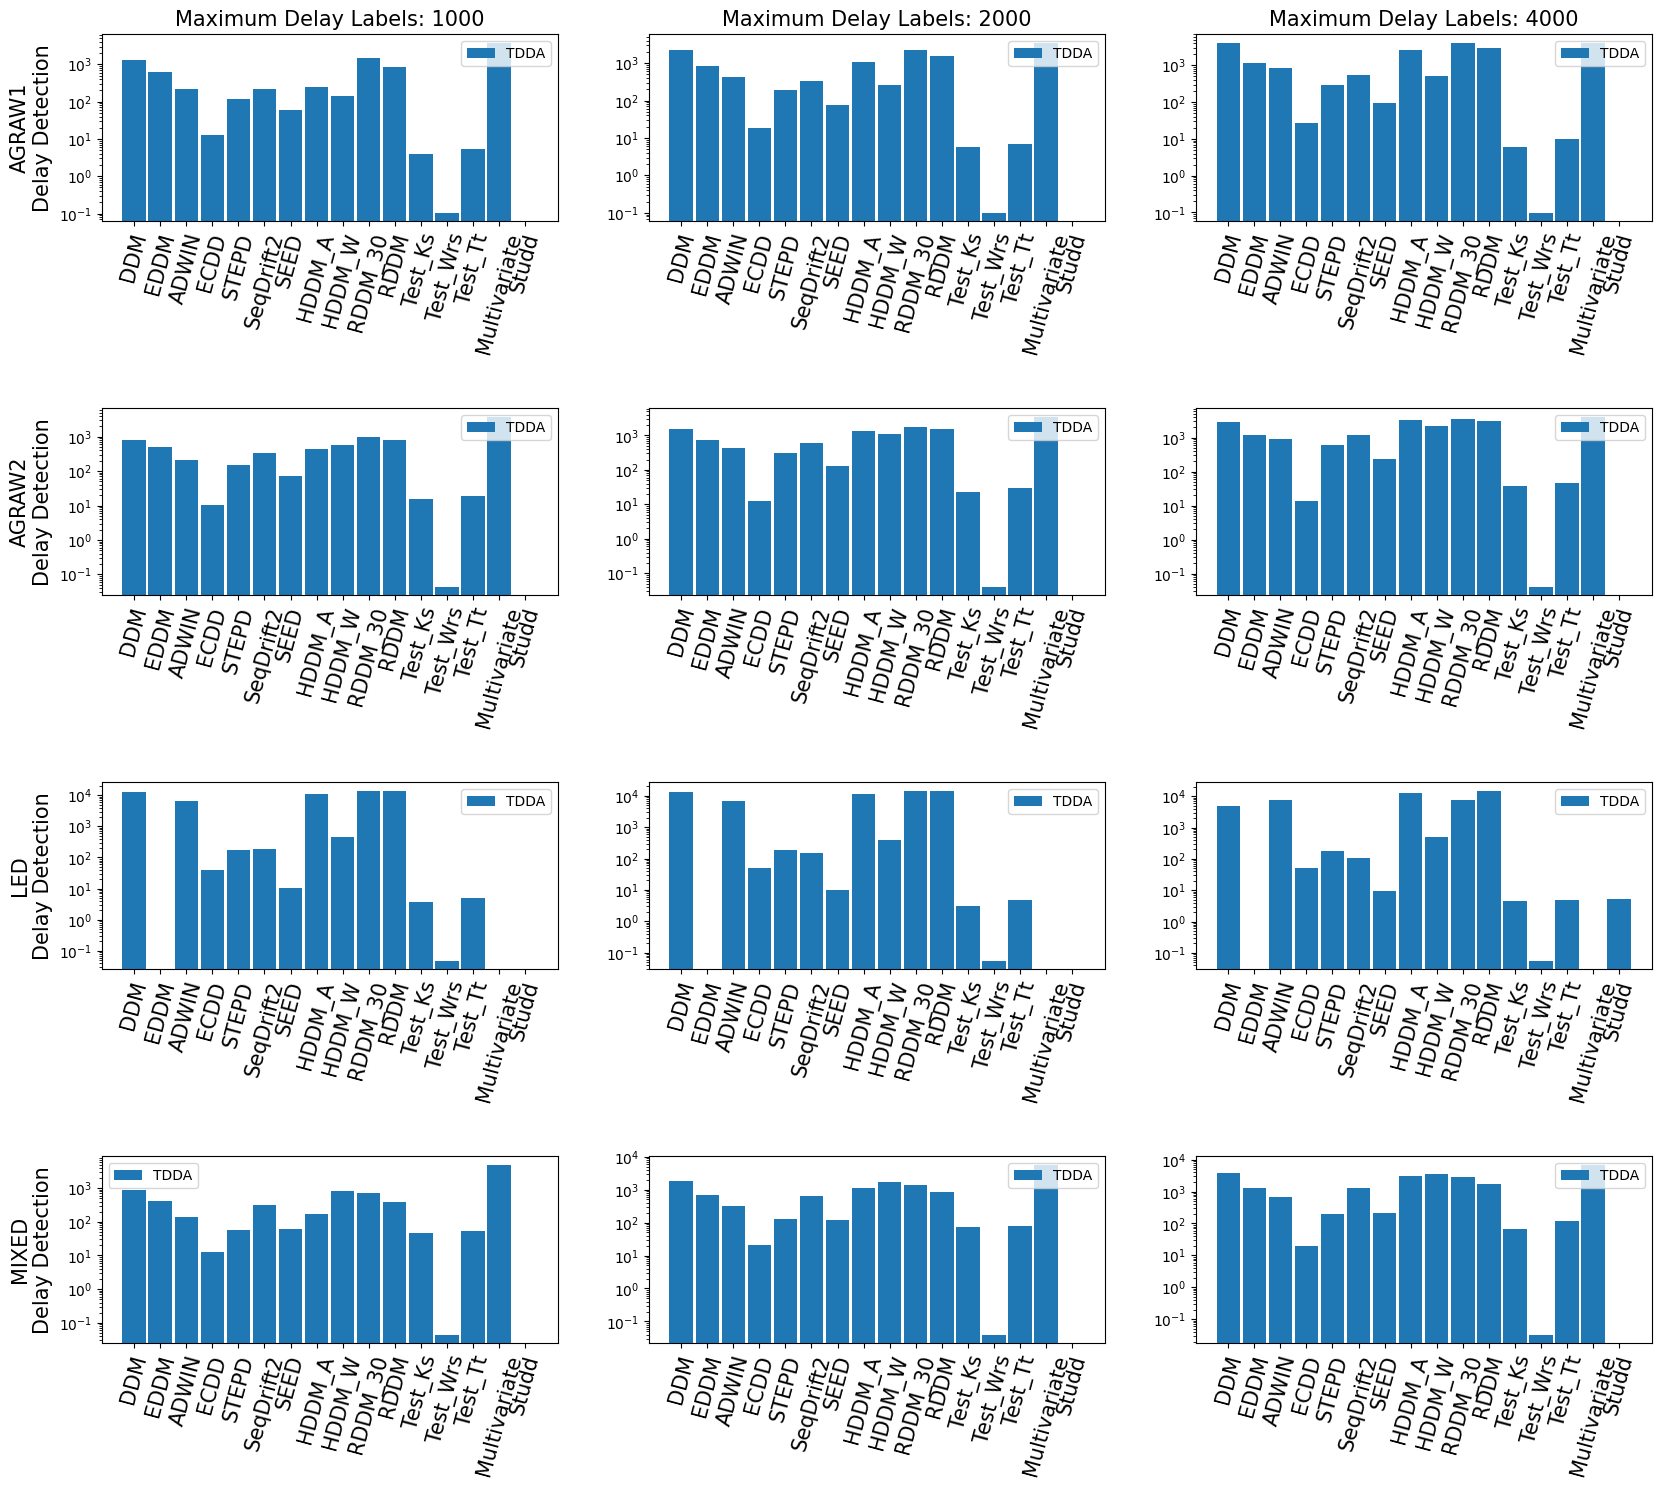

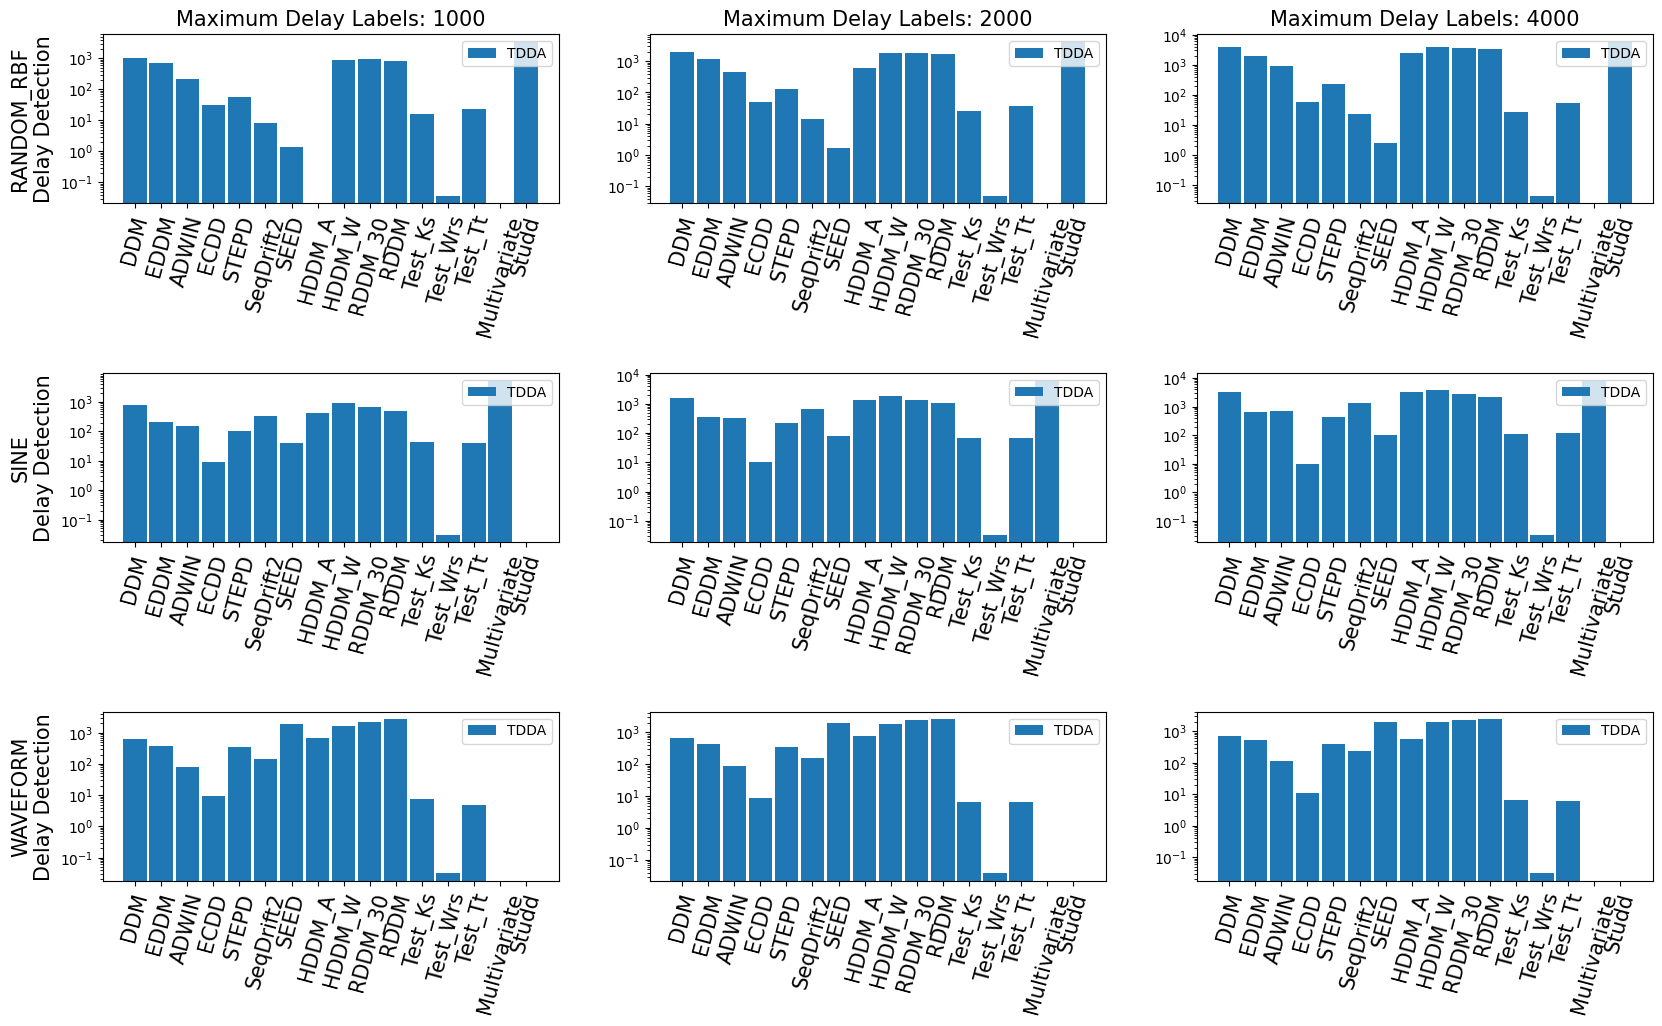

In [20]:
drift_size = 100000
#partialy_drift options: 95, 96, 97, 98, 99
delay_labeled = [1000, 2000, 4000]
type_drift = "Gradual"
#metric name options: detected changes, detected warnings, delay detection (average), delay true detection (average), MTFA (average), MDR, true changes detected, 
metric_name = "delay true detection (average)"
metric_name_label = "Delay Detection"
label_bar = "TDDA"
df = pd.read_csv(f'../results/delay/csv_aggregation/{type_drift}_{metric_name}_{drift_size}.csv')

data_sets_v1 = ['AGRAW1', 'AGRAW2', 'LED', 'MIXED']
data_sets_v2 = ['RANDOM_RBF', 'SINE', 'WAVEFORM']

fig_size_1 = (20,17)
fig_size_2 = (20,11)

generate_bar_plot_metric(df, data_sets_v1, delay_labeled, metric_name_label, type_drift, drift_size, fig_size_1, label_bar, y_log=True, part=1, folder_name="delay_plots_aggregation_v2")
generate_bar_plot_metric(df, data_sets_v2, delay_labeled, metric_name_label, type_drift, drift_size, fig_size_2, label_bar, y_log=True, part=2, folder_name="delay_plots_aggregation_v2")

## Abrupt Drift and Delay Labeled Data Stream 1k, 2k, 8k (TDDA)

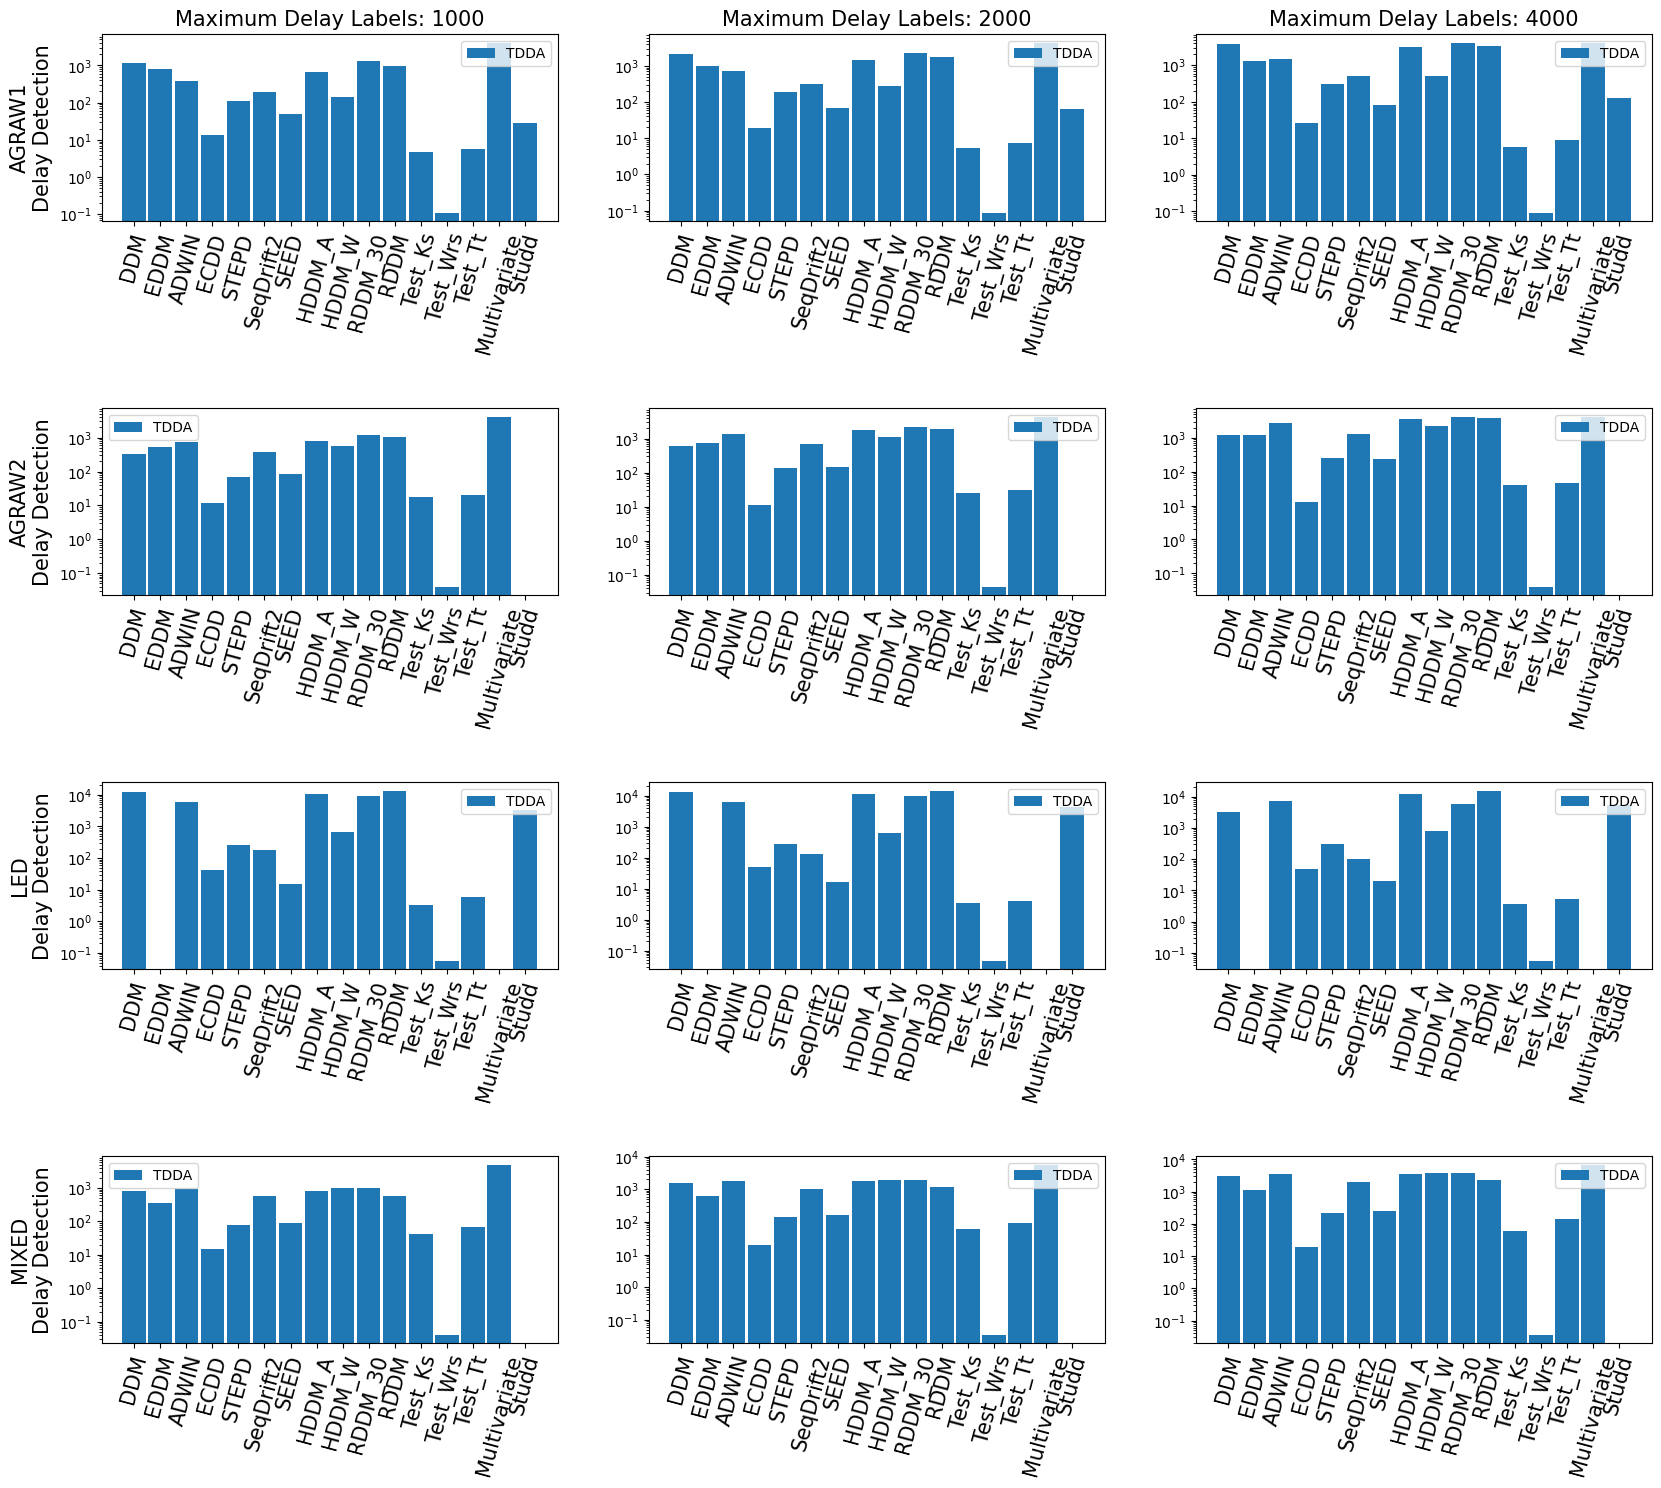

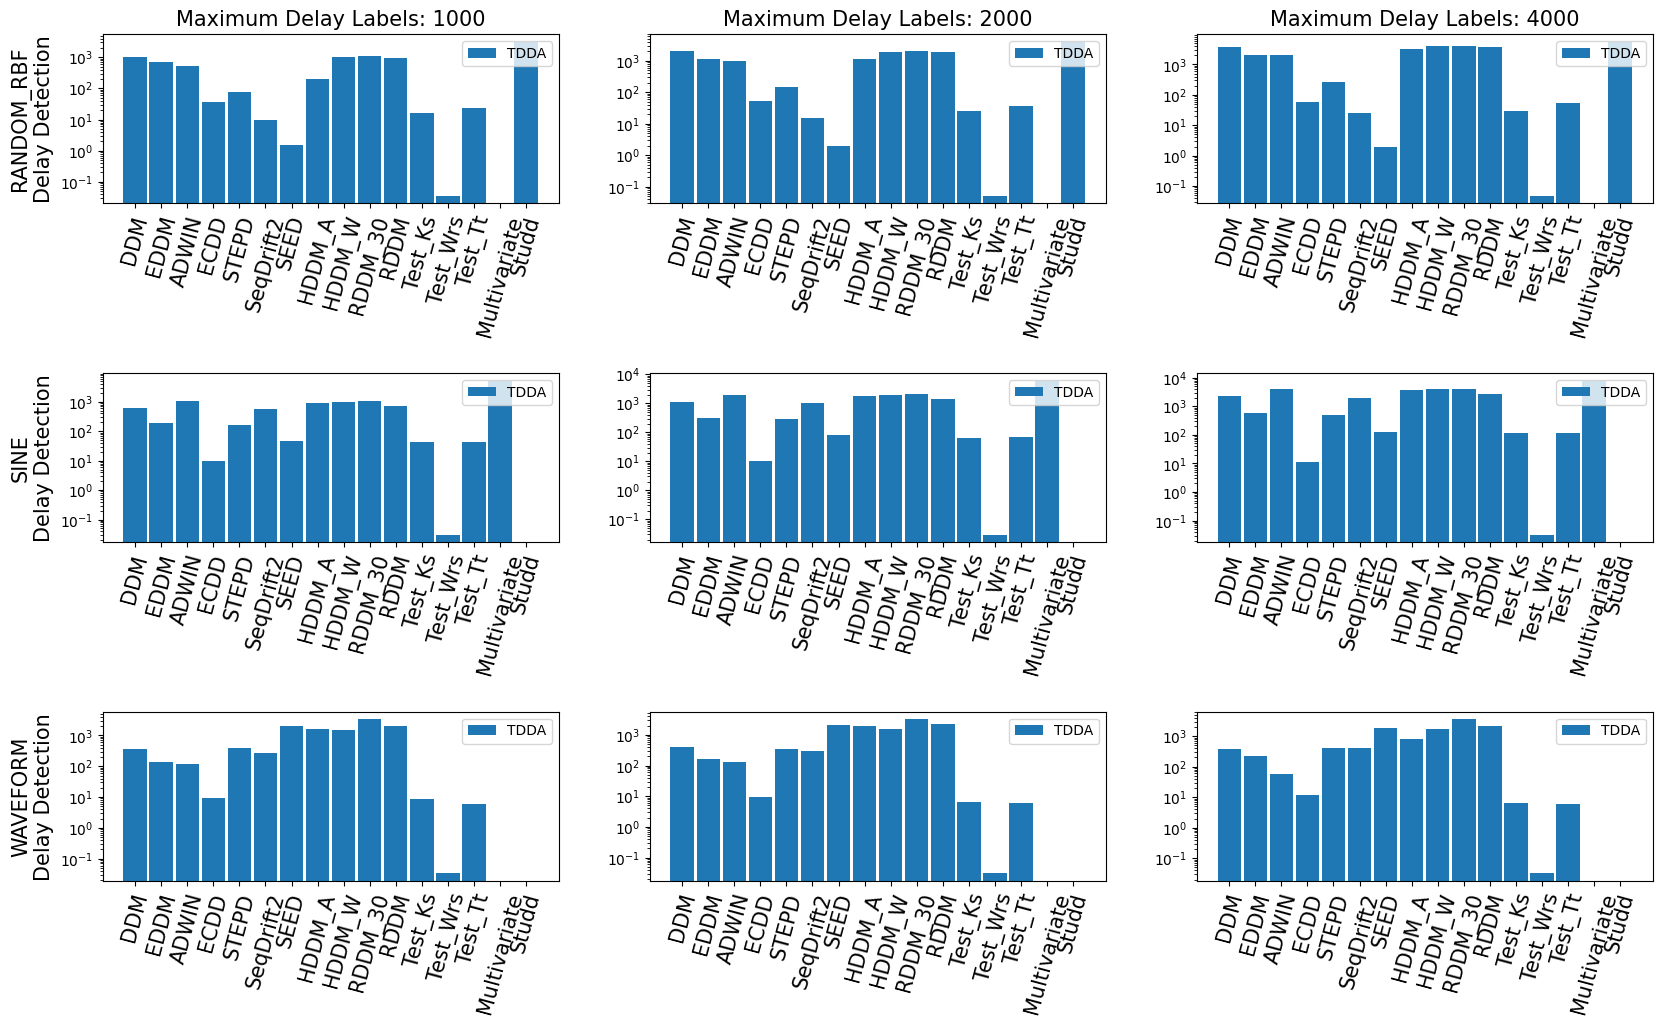

In [21]:
drift_size = 100000
#partialy_drift options: 95, 96, 97, 98, 99
delay_labeled = [1000, 2000, 4000]
type_drift = "Abrupt"
#metric name options: detected changes, detected warnings, delay detection (average), delay true detection (average), MTFA (average), MDR, true changes detected, 
metric_name = "delay true detection (average)"
metric_name_label = "Delay Detection"
label_bar = "TDDA"
df = pd.read_csv(f'../results/delay/csv_aggregation/{type_drift}_{metric_name}_{drift_size}.csv')

data_sets_v1 = ['AGRAW1', 'AGRAW2', 'LED', 'MIXED']
data_sets_v2 = ['RANDOM_RBF', 'SINE', 'WAVEFORM']

fig_size_1 = (20,17)
fig_size_2 = (20,11)

generate_bar_plot_metric(df, data_sets_v1, delay_labeled, metric_name_label, type_drift, drift_size, fig_size_1, label_bar, y_log=True, part=1, folder_name="delay_plots_aggregation_v2")
generate_bar_plot_metric(df, data_sets_v2, delay_labeled, metric_name_label, type_drift, drift_size, fig_size_2, label_bar, y_log=True, part=2, folder_name="delay_plots_aggregation_v2")

## Abrupt Drift and Delay Labeled Data Stream 10k, 8k (TDDA)

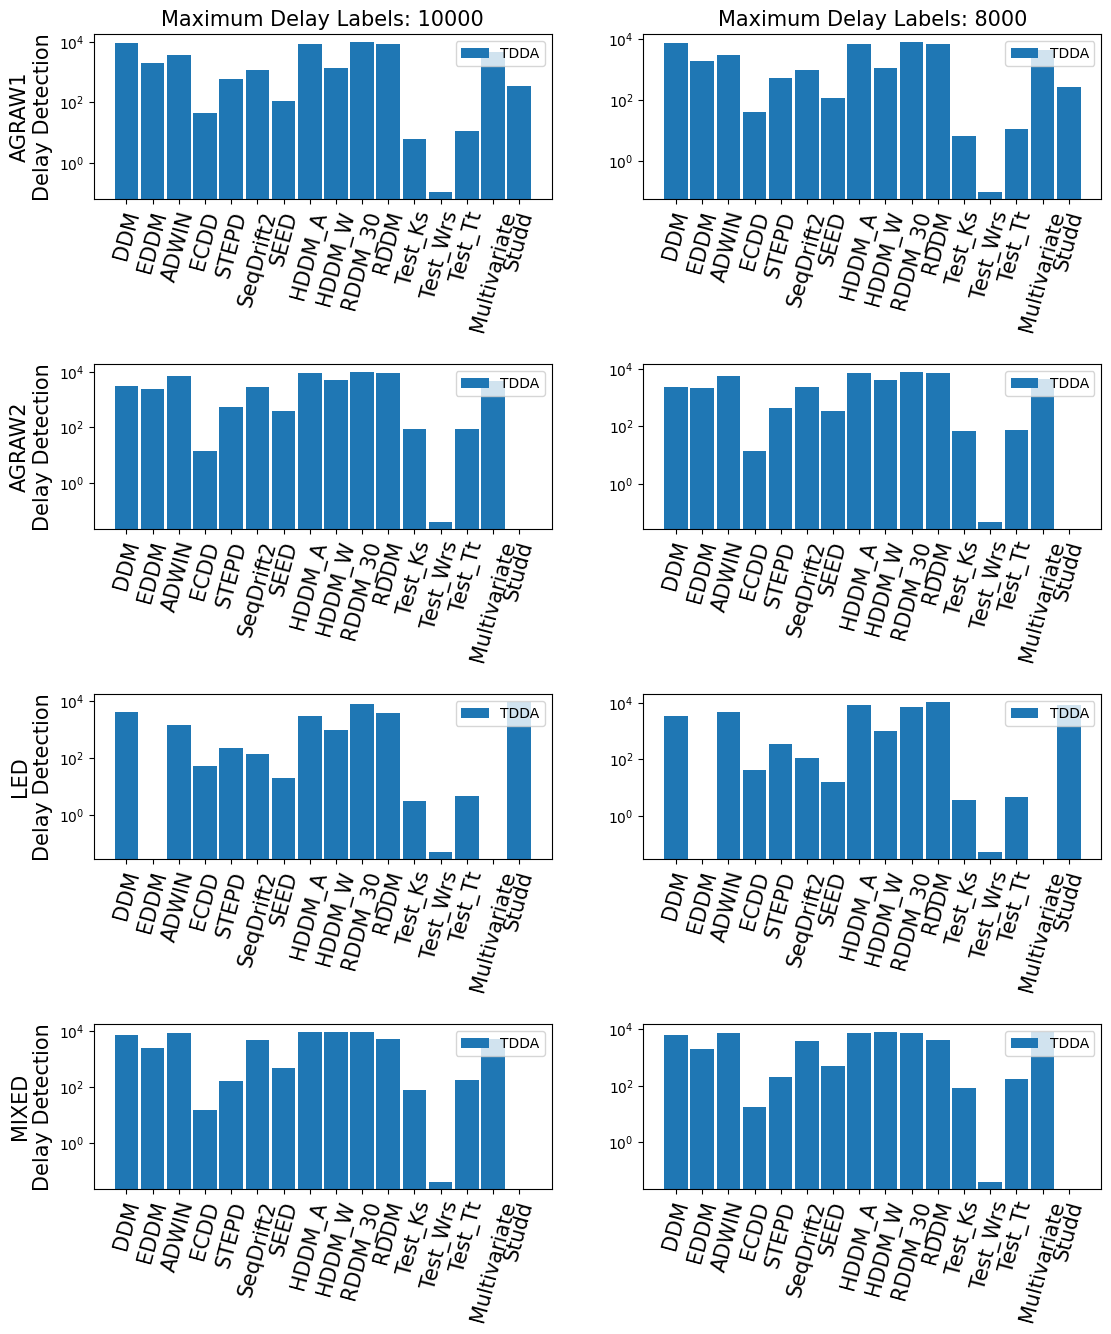

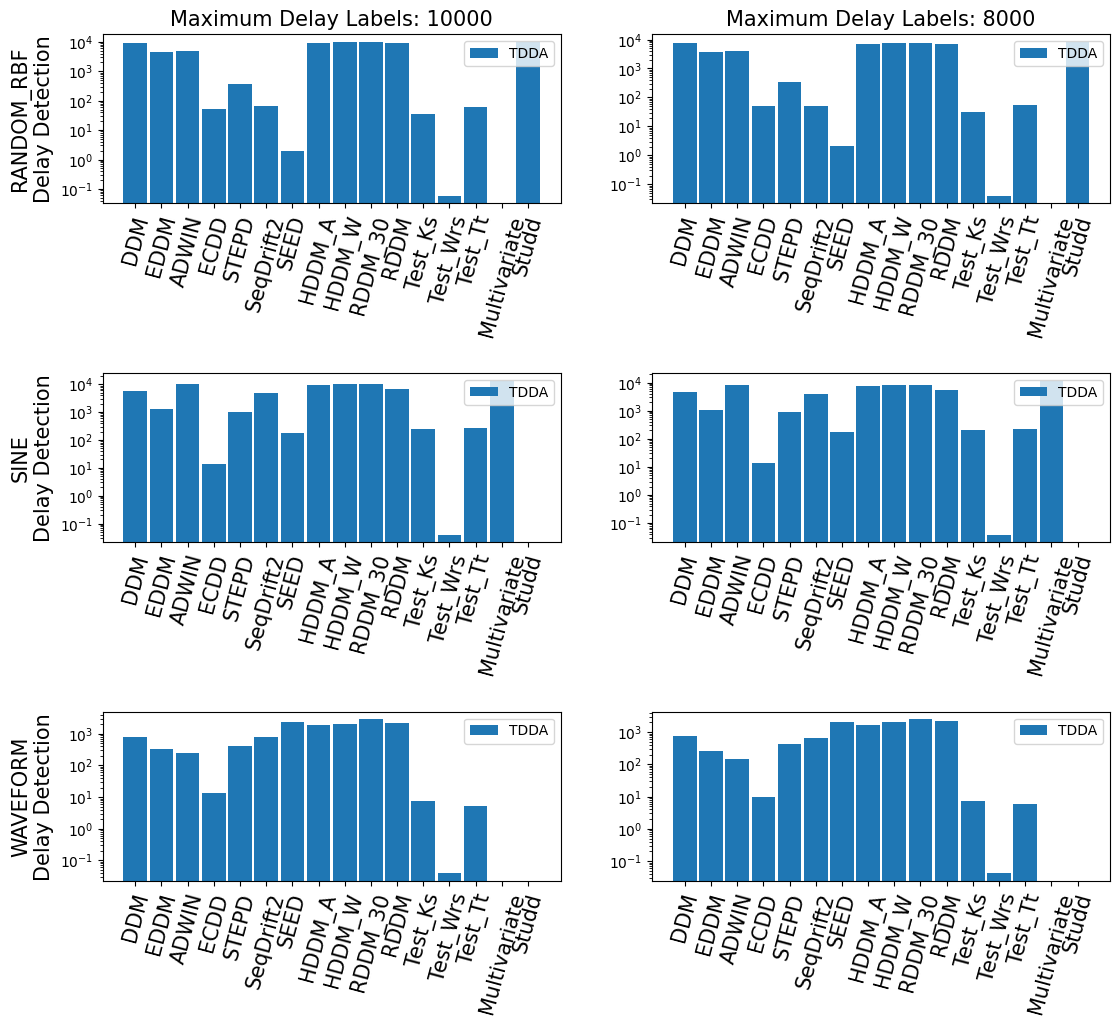

In [22]:
drift_size = 100000
#partialy_drift options: 95, 96, 97, 98, 99
delay_labeled = [10000, 8000]
type_drift = "Abrupt"
#metric name options: detected changes, detected warnings, delay detection (average), delay true detection (average), MTFA (average), MDR, true changes detected, 
metric_name = "delay true detection (average)"
metric_name_label = "Delay Detection"
label_bar = "TDDA"
df = pd.read_csv(f'../results/delay/csv_aggregation/{type_drift}_{metric_name}_{drift_size}.csv')

data_sets_v1 = ['AGRAW1', 'AGRAW2', 'LED', 'MIXED']
data_sets_v2 = ['RANDOM_RBF', 'SINE', 'WAVEFORM']

fig_size_1 = (13,15)
fig_size_2 = (13,11)

generate_bar_plot_metric(df, data_sets_v1, delay_labeled, metric_name_label, type_drift, drift_size, fig_size_1, label_bar, y_log=True, part=1, folder_name="delay_plots_aggregation_v2")
generate_bar_plot_metric(df, data_sets_v2, delay_labeled, metric_name_label, type_drift, drift_size, fig_size_2, label_bar, y_log=True, part=2, folder_name="delay_plots_aggregation_v2")